# Capstone project 2: Application Recommendation System for Biodegradable Polymer

**Problem and Goal:**  
Developing new applications of a polymer is one of the most important and challenging steps to sell a polymer as a product. It requires a wide range of knowledge about polymer itself (physical property, formability, etc.) and products that might already exist or might not yet. The goal of this project is to make an application recommendation system that gives some hints about potential applications for a given polymer by a user. A biodegradable polymer has been chosen as a polymer kind for this project.

**Abstract:**  
Patent information was used for this project, and the data were acquired from [WIPO](https://patentscope.wipo.int/search/en/search.jsf). To understand the data and make a decent model, the exploratory data analysis was implemented about the countries, polymer kinds, application kinds, and language variety of the abstracts. According to a pre-trained language identification model by [fastText](https://fasttext.cc/), the data included 19 kinds of languages in the abstracts, and 90% of the abstracts were written in English or Japanese. This wide language variety made this project more complicated, interesting, and worth pursuing to obtain multi-skills. I decided to use English and Japanese abstracts to calculate the sentence similarities so that they could be used to prioritize the recommendation.  
  
Two application recommendation systems were created. One system accepts one patent and another accepts two IPC codes as input by a user, and they provide 10 potential applications. The recommendation systems use two features to extract potential applications, a network and sentence similarity. The network has information about patents and IPC codes, and is used to extract the neighbor patents of an input patent (or two IPC codes.) Sentence similarities of patent abstracts were calculated by cosine similarity. The similarities are used to prioritize the neighbor patents so that the system can pick up the most similar patents and therefore the most prospective applications.  

< skills and methods used >  
language identification (fastText) / language translation (googletranslate) / text preprocessing (regular expressions, tokenization, stop words, stemming) / vectorization (Tf-idf) / sentence similarity (cosine similarity) / network analysis (NetworkX) / degree centrality / unit test 

## Table of Contents

1. Load Data  
2. Exploratory Data Analysis  
3. Data Wrangling  
4. Modeling  
5. Recommend Applications (using the Model)  
6. Summary

## 1. Load Data

Patents are used to make the recommendation systems. A patent includes information about what polymer was used, how to prepare it, for what it could be used, who invented it, and so on. The material and application data would provide useful information for this project.  
  
  
The patent data was acquired from the database of the [World Intellectual Property Organization (WIPO)](https://patentscope.wipo.int/search/en/search.jsf) with a search word “IC:(C08L 101/16)”. The dataset includes patents categorized into "C08B 101/16" and released by Jun.2.2020. C08L 101/16 is the IPC code (International Patent Classification code) for biodegradable polymers. IPC is a hierarchical patent classification system. All technical fields are divided into 8 "sections" from A to H:  
  
-A: Human Necessities  
-B: Performing Operations, Transporting  
-C: Chemistry, Metallurgy  
-D: Textiles, Paper  
-E: Fixed Constructions  
-F: Mechanical Engineering, Lighting, Heating, Weapons, Blasting  
-G: Physics  
-H: Electricity  
  
There are "classes" in each section, and each class has "subclasses". Then, there are "maingroups" under a subclass, and finally "subgroups".  For example, C08L 101/16 means:  
  
(Section)   C: Chemistry, Metallurgy  
(Class)     C08: Organic macromolecular compounds, Preparation or chemical working-up    
(Subclass)  C08L: Macromolecular compounds  
(Maingroup) C08L 101: Unspecified macromolecular compounds  
(Subgroup)  C08L 101/16: Biodegradable macromolecular compounds  
  
Each IPC code represents a material, application, or technology to manufacture it. The patent information in WIPO is collected from [193 member countries](https://www.wipo.int/members/en/). The coverage is [wide](https://patentscope.wipo.int/search/en/help/data_coverage.jsf), but not exhaustive. 
  
  
Load the data and check the general information.

In [1]:
# Import the packages
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
# import datetime
import matplotlib.dates as mdates
from collections import Counter
import itertools
import re
from fastText import load_model
from iso_language_codes import *
from googletrans import Translator
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import nxviz as nv
# import csv
import unittest

# Import a pre-trained model for language identification (from fastText)
li_model = load_model("lid.176.bin")

# Set a style for a plot
sns.set(context='notebook', style='ticks', palette='hls')

# Set a style for a DataFrame
pd.set_option("display.max_colwidth", 100)

In [2]:
# You can see this notebook without codes
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Load the csv file 
raw_data_file = 'C08L10116_csv.csv'
df= pd.read_csv(raw_data_file)

print('Raw data')
print('df (first row):')
df.head(1)

Raw data
df (first row):


,Application Id,Application Number,Application Date,Country,Title,Abstract,I P C,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN


In [4]:
# Rename the column names
df = df.rename(columns={'Application Id': 'Patent_Id', 
                        'Application Number': 'Application_Number', 
                        'Application Date': 'Application_Date',
                        'I P C': 'IPC'})

print('Raw data after renaming the columns')
print('df (first 5 rows):')
df.head()

Raw data after renaming the columns
df (first 5 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


This dataset includes worldwide patents, and the language is not limited in English. 

In [5]:
# Check the general information
print('The general information of "df":')
df.info()

The general information of "df":
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Patent_Id           8182 non-null   object
 1   Application_Number  8135 non-null   object
 2   Application_Date    8165 non-null   object
 3   Country             8182 non-null   object
 4   Title               8172 non-null   object
 5   Abstract            7604 non-null   object
 6   IPC                 8182 non-null   object
 7   Applicants          8025 non-null   object
 8   Inventors           8027 non-null   object
dtypes: object(9)
memory usage: 575.4+ KB


This dataset includes 8,182 patents. The five columns other than 'Patent_Id', 'Country', and 'IPC' have missing data.

In [6]:
# Check duplicate rows and application IDs
print('The number of duplicate rows:', list(df.duplicated()).count(True))
print('The number of duplicate Patent_Ids:', list(df['Patent_Id'].duplicated()).count(True))

The number of duplicate rows: 0
The number of duplicate Patent_Ids: 0


Each row is unique, and there is no duplicate patent ID. 

## 2. Exploratory Data Analysis

Before starting to prepare for the modeling, take a look at the data to know what should be in mind.

2.1. Countries where patents were filed    
2.2. Explore IPC codes  
2.3. Popular polymers  
2.4. Popular applications (big category)  
2.5. Popular applications in the medical category (A61)  
2.6. Language variety

### 2.1. Countries where patents were filed

The 'Country' column in the data shows which country a patent was registered in. It would be connected to the market. Check the country variety and which countries are frequent.

In [7]:
# Assert statement: 'Country' column doesn't have any missing value
assert df['Country'].isnull().any() == False

# How many countries
print('The number of countries:', df['Country'].nunique(), 'countries')

The number of countries: 37 countries


<IPython.core.display.Javascript object>


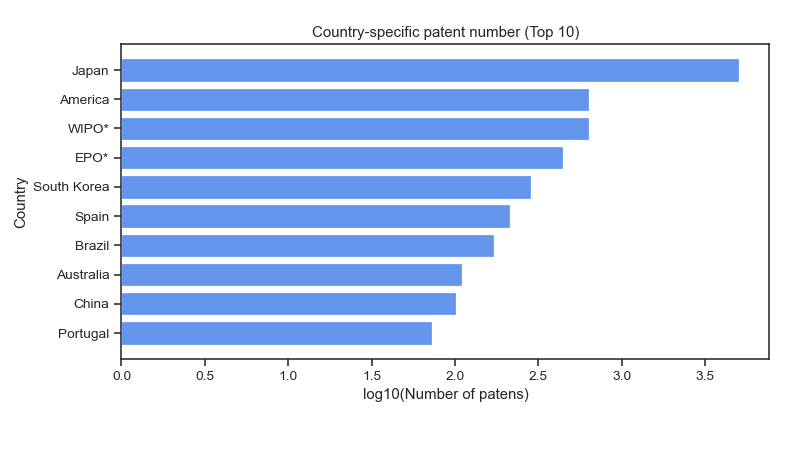

In [8]:
# Count the total patent number of each country
patent_byCountry = Counter(df['Country']).most_common()

# Extract the top 10 countries and the numbers of patents, and reverse the orders
top10_countries_list = list(reversed(patent_byCountry[:10]))

# Prepare an abbreviation dictionary
abbre_country_dict = {'JP': 'Japan',
                      'US': 'America',
                      'WO': 'WIPO*',
                      'EP': 'EPO*',
                      'KR': 'South Korea',
                      'ES': 'Spain',
                      'BR': 'Brazil',
                      'AU': 'Australia',
                      'CN': 'China',
                      'PT': 'Portugal'}

# Draw a bar plot of the top 10 countries
plt.figure(figsize=(9,5))

x_counts = [np.log10(country[1]) for country in top10_countries_list]
y_abbreCountry = [country[0] for country in top10_countries_list]
y_countries = [abbre_country_dict[abb] for abb in y_abbreCountry]

plt.barh(y_countries, x_counts, color='cornflowerblue')

plt.xlabel('log10(Number of patens)')
plt.ylabel('Country')
plt.title('Country-specific patent number (Top 10)')

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.90)
plt.show()

* WIPO = World Intellectual Property Organization  
* EPO = European Patent Office

The patent data is from 37 countries (and organizations). Japan and America are the largest groups. The recommended applications by the system will tend to be for products that are popular in those countries.

### 2.2. Explore IPC Codes

The DataFrame 'df' has a column called 'IPC.' This column shows the IPC codes the patent is categorized in. In this section, the following three points are explored.

2.2.1. Number of IPC codes per patent  
2.2.2. Number of IPC code kinds  
2.2.3. Frequency of each IPC code in data

#### 2.2.1. Number of IPC codes per patent 

The number of IPC codes per patent is directly related to the number of connections with other patents. If a patent has many connections with other patents, the patent is more likely to appear in the searching result. 

In [9]:
# Assert statement: 'IPC' column doesn't have any missing value
assert df['IPC'].isnull().any() == False

# A dictionary to store patent IDs and the IPC codes
patent_ipc_dict = {}

# Store patent IDs and the IPC codes in the dictionary
for i in range(len(df)):
    # Extract the IPC codes
    ipcs = df.loc[i, 'IPC']
    
    # Split the IPC codes and keep them in a set
    ipc_set = set(re.findall('[A-Z][0-9]+[A-Z][ ][0-9]+/[0-9]+', ipcs))
    
    # Remove 'C08L 101/16' (because all patents have this IPC code)
    ipc_set.remove('C08L 101/16')
    
    # Add the ipc_set in the patent_ipc_dict
    patent_ipc_dict[df.loc[i, 'Patent_Id']] = ipc_set

<IPython.core.display.Javascript object>


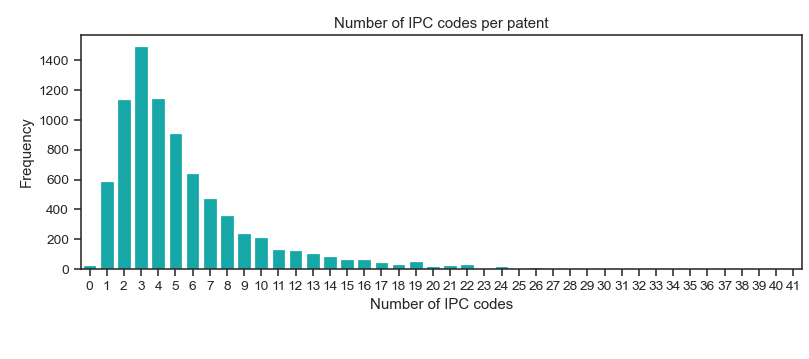

In [10]:
# Count the number of IPC codes per patent
numIpcs_perPatent_list = list(map(lambda ipcs: len(ipcs), patent_ipc_dict.values()))

# Draw a count plot
plt.figure(figsize=(9,4))

sns.countplot(x=numIpcs_perPatent_list, color='c')
plt.ylabel('Frequency')
plt.xlabel('Number of IPC codes')
plt.title('Number of IPC codes per patent')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.25, top=0.90)
plt.show()

The peak of the distribution was 3. Some patents do not have any IPC codes (other than 'C08L 101/16'). They do not have any connection when the network is drawn. Check if the patents have an abstract so that it can be used to search the relationships with other patents instead of IPC codes. 

In [11]:
# Get the Patent_Ids of patents not having any IPC code 
noIpc_patents_list = [k for k, v in patent_ipc_dict.items() if len(v) == 0]

# Show the 'df' rows of the patents
print('Patents having only "C08L 101/16" as an IPC code:')
print(len(df[df['Patent_Id'].isin(noIpc_patents_list)]), 'patents')
df[df['Patent_Id'].isin(noIpc_patents_list)].head()

Patents having only "C08L 101/16" as an IPC code:
25 patents


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
229,MX236552233,2017005889,04.05.2017,MX,SÍNTESIS DE UN COPOLÍMERO INJERTO BIODEGRADABLE CAPAZ DE FORMAR PELÍCULA DE BAJA ADSORCIÓN.,The present invention discloses the synthesis of a biodegradable graft copolymer of low adsorpti...,C08L 101/16,UNIVERSIDAD DE GUANAJUATOUNIVERSIDAD DE GUANAJUATO,José Luis MATA MATA; Aurelio RAMÍREZ HERNÁNDEZ; Alejandro APARICIO SAGUILAN
651,MY203067723,PI 2014002784,29.09.2014,MY,A PROCESS FOR FULLY COMPOSTING BIODEGRADABLE HIGH PERFORMANCE PLASTIC MATERIALS,THE PRESENT INVENTION PROVIDES A PROCESS FOR FULLY COMPOSITING BIODEGRADABLE HIGH PERFORMANCE PL...,C08L 101/16,HENG HIAP INDUSTRIES SDN BHD,SEAH KIAN HOE
1214,CN85366070,201210198111.9,15.06.2012,CN,Production method of biodegradable medical plastics,The invention discloses a production method of environment-friendly biodegradable medical plasti...,C08L 101/16,"Yancheng Jinwo Medical Technology Co., Ltd.",Wang Jun
1477,MX130518126,2011008209,04.08.2011,MX,"PROCESO PARA LA ELABORACIÓN DE PELÍCULAS A PARTIR DE CÍTRICOS, LAS PELÍCULAS Y SU USO COMO EMPAQ...","The present invention refers to a process for the manufacture of films from citrus, the films an...",C08L 101/16,INSTITUTO TECNOLOGICO Y DE ESTUDIOS SUPERIORES DE MONTERREYINSTITUTO TECNOLOGICO Y DE ESTUDIOS S...,HUGO MUJICA PAZ; JOCELIN GABRIELA HERNANDEZ CARRILLO; JORGE WELTI CHANES; AURORA VALDEZ FRAGOSO
1631,ID202886819,P00201100008,06.01.2011,ID,SUATU MATERIAL BARU FILM PLASTIK MESRA ALAM CAMPURAN POLI (3-HIDROKSI BUTIRAT) DENGAN POLISTIREN,Suatu material baru berupa filem plastik ramah lingkungan terbuat dari campuran polistiren(PS) d...,C08L 101/16,Prof. Dr. Akmal Djamaan,Akmal Djamaan


24 patents have only "C08L 101/16" as an IPC code, and one patent has an incomplete code and "C08L 101/16". 20 out of 25 patents have an English abstract, and the abstracts would be used to calculate the similarities to other patents. They will still be active in the system. On the other hand, the remaining 5 patents (ID202886819, AR10512058, BR6371648, KR149646441, and DE104259751) will never show up in the result even though the information is in the network data.  

#### 2.2.2. Number of IPC code kinds

In [12]:
# Flatten the values of patent_ipc_dict (using itertools library)
all_ipcs_list = list(itertools.chain.from_iterable(patent_ipc_dict.values()))

# Count the IPC codes
ipc_freq = Counter(all_ipcs_list)

print('The number of IPC code kinds:', len(ipc_freq))

The number of IPC code kinds: 4344


There are 4,344 kinds of IPC codes in the data. Each IPC code represents a material, application, or technology to manufacture it. When the network is created, the 4,344 IPC codes will be one kind of the nodes. Another kind of nodes will be patents (8,182). That is, the network will have 12,526 nodes in total. 

#### 2.2.3. Frequency of each IPC code in data

Here, the frequency of each IPC code is analyzed. Some IPC codes are very frequent, and some are not. This is connected with the number of edges of the network.

In [13]:
# Sort the dictionary by the frequency
ipc_freq_sorted = dict(sorted(ipc_freq.items(), key=lambda x: x[1], reverse=True))
ipc_freq_sorted_values = list(ipc_freq_sorted.values())               

print('The frequency distribution of IPC codes:')
# Show the summary statistics as a DataFrame
pd.DataFrame(pd.Series(ipc_freq_sorted_values).describe()).transpose()

The frequency distribution of IPC codes:


,count,mean,std,min,25%,50%,75%,max
0,4344.0,10.592081,60.43464,1.0,1.0,2.0,6.0,2830.0


In [14]:
# The number of IPC codes appearing only once
print('The number of IPC codes appearing only once:', ipc_freq_sorted_values.count(1))

# Percentage of IPC codes having one connection 
print('The percentage of IPC codes appearing once:', 
      round(ipc_freq_sorted_values.count(1)/len(ipc_freq)*100, 1), '%')

The number of IPC codes appearing only once: 1665
The percentage of IPC codes appearing once: 38.3 %


<IPython.core.display.Javascript object>


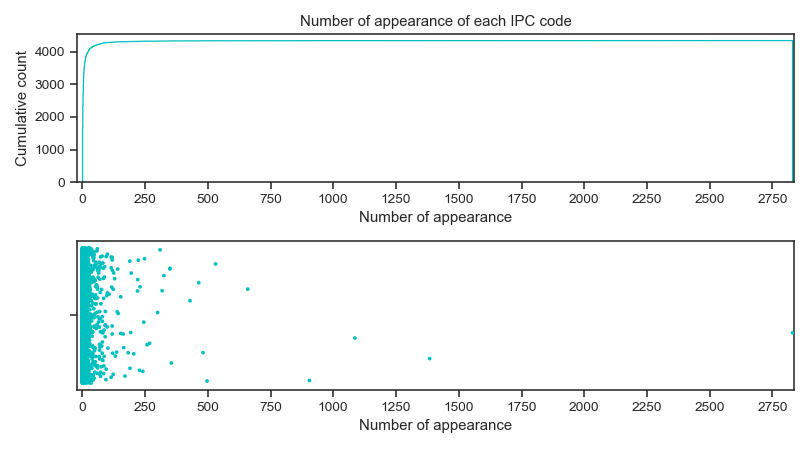

In [15]:
# Draw a count plot and a strip plot
plt.figure(figsize=(9,5))

plt.subplot(2,1,1)
plt.hist(ipc_freq_sorted_values, bins=2830, cumulative=True, histtype='step', color='c')
plt.xlim([-20, 2835])
plt.xticks(range(0, 3000, 250))
plt.xlabel('Number of appearance')
plt.ylabel('Cumulative count')
plt.title('Number of appearance of each IPC code')

plt.subplot(2,1,2)
sns.stripplot(x=ipc_freq_sorted_values, size=3, color='c', jitter=True) 
plt.xlim([-20, 2835])
plt.xticks(range(0, 3000, 250))
plt.xlabel('Number of appearance')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


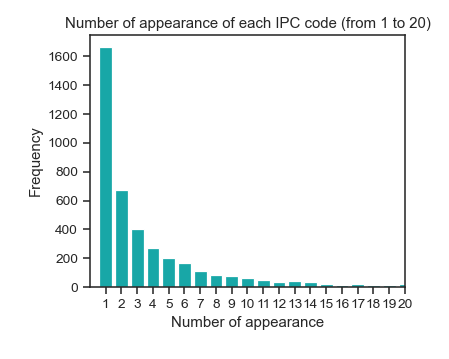

In [16]:
# Draw a bar plot of the number of appearance of each IPC code (from 1 to 20)
plt.figure(figsize=(5,4))

sns.countplot(x=ipc_freq_sorted_values, color='c')
plt.xlim([-1,19])
plt.ylabel('Frequency')
plt.xlabel('Number of appearance')
plt.title('Number of appearance of each IPC code (from 1 to 20)')

plt.subplots_adjust(left=0.2, right=0.90, bottom=0.2, top=0.90)
plt.show()

In [17]:
# Check the IPC codes of the top 10 appearance
print('The frequent IPC codes (Top 5):')
ipc_freq.most_common(5)

The frequent IPC codes (Top 5):


[('C08L 67/04', 2830),
 ('C08L 101/00', 1384),
 ('C08L 67/00', 1086),
 ('C08J 5/18', 905),
 ('C08L 67/02', 659)]

- C08L 67/04: Polyesters derived from hydroxy carboxylic acids (e.g. lactones)  
- C08L 101/00: Unspecified macromolecular compounds  
- C08L 67/00: Polyesters obtained by reactions forming a carboxylic ester link in the main chain  
- C08J 5/18: Manufacture of films or sheets      
- C08L 67/02: Polyesters derived from dicarboxylic acids and dihydroxy compounds   

1,665 (38%) IPC codes appear only once. It means they are not much useful to predict applications because the network ends at the IPC codes. However, a user might input the IPC codes and want to start from them to find other applications. So keep them. On the other hand, at least five IPC codes appear more than 600 times. This means there are more than 600 connections once reaching the IPC codes. To prioritize the applications, using the similarities of abstracts would be the key. 

### 2.3. Popular polymers

Here, I extract the subclasses representing polymers, that is, 'C08L'. Then, the maingroups are counted to identify the popular polymers in the dataset. The maingroups of 'C08L' represent a polymer kind. For example, 'C08L 1' is 'cellulose', and 'C08L 67' is 'polyesters'. There are two more nested categories indicated after '/', but use the maingroup category (until just before '/') in this section.  

Extract IPC codes beginning with 'C08L'.

In [18]:
# Make a dictionary to keep an IPC code (maingroup level) as a key and the number as a value
C08L_count_dict = {}

# Extract keyes having 'C08L' and the values
for k, v in ipc_freq.items():
    if k[:4] == 'C08L':
        ipc_maingroup = re.search('C08L [0-9]+', k).group()
        if ipc_maingroup in C08L_count_dict.keys():
            C08L_count_dict[ipc_maingroup] += v
        else:
            C08L_count_dict[ipc_maingroup] = v

# Sort by the frequency
C08L_count_dict_sorted = sorted(C08L_count_dict.items(), key=lambda x:x[1]) 

# Show how many kinds of polymers are in the data
print('The number of polymer kinds:', len(C08L_count_dict_sorted))

The number of polymer kinds: 49


<IPython.core.display.Javascript object>


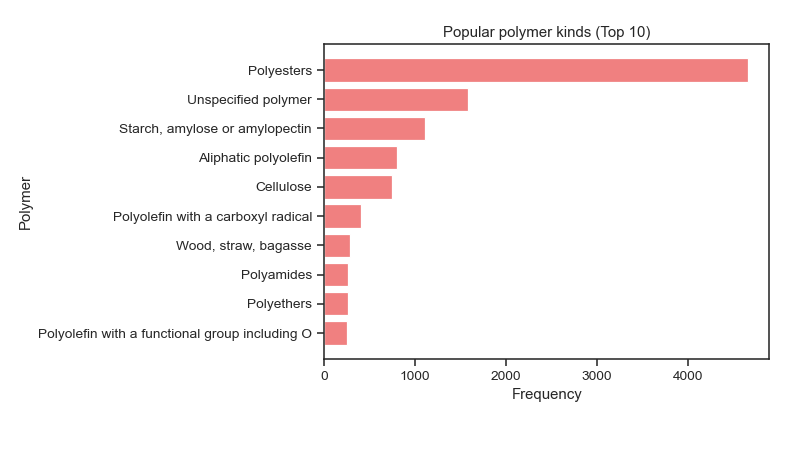

In [19]:
# Prepare a code_name dictionary
abbre_polymer_dict = {'C08L 67': 'Polyesters',
                      'C08L 101': 'Unspecified polymer',
                      'C08L 3': 'Starch, amylose or amylopectin',
                      'C08L 23': 'Aliphatic polyolefin',
                      'C08L 1': 'Cellulose',
                      'C08L 33': 'Polyolefin with a carboxyl radical',
                      'C08L 97': 'Wood, straw, bagasse',
                      'C08L 77': 'Polyamides',
                      'C08L 71': 'Polyethers',
                      'C08L 29': 'Polyolefin with a functional group including O'}

# Draw a bar plot of the top 10 polymers
plt.figure(figsize=(9,5))

x_counts = [tup[1] for tup in C08L_count_dict_sorted[-10:]]
top10_polymers = [tup[0] for tup in C08L_count_dict_sorted[-10:]]
y_polymers = [abbre_polymer_dict[abb] for abb in top10_polymers]

plt.barh(y_polymers, x_counts, color='lightcoral')

plt.xlabel('Frequency')
plt.ylabel('Polymer')
plt.title('Popular polymer kinds (Top 10)')

plt.subplots_adjust(left=0.4, right=0.95, bottom=0.2, top=0.90)
plt.show()

There are 49 kinds of polymers in the data, and polyesters are the most popular. This would be because polylactic acid and polyglycolic acid are very popular in biodegradable polymers.   

### 2.4. Popular applications (big category)

First, I need to decide what IPC codes are treated as applications. I carefully checked the IPC classes and extracted the following IPC classes as applications.

### < IPC Classes for Applications >
**A: HUMAN NECESSITIES** (all classes)   
  
**B: PERFORMING OPERATIONS; TRANSPORTING** (following classes)  
- B09: DISPOSAL OF SOLID WASTE, RECLAMATION OF CONTAMINATED SOIL    
- B27: WORKING OR PRESERVING WOOD, NAILING OR STAPLING MACHINES    
- B28: WORKING CEMENT, CLAY, OR STONE  
- B31: MAKING ARTICLES OF PAPER, CARDBOARD OR MATERIAL, WORKING PAPER, CARDBOARD OR MATERIAL       
- B41: PRINTING, LINING MACHINES, TYPEWRITERS, STAMPS    
- B42: BOOKBINDING, ALBUMS, FILES, SPECIAL PRINTED MATTER    
- B43: WRITING OR DRAWING IMPLEMENTS, BUREAU ACCESSORIES   
- B44: DECORATIVE ARTS   
- B60: VEHICLES       
- B61: RAILWAYS     
- B62: LAND VEHICLES FOR TRAVELLING OTHERWISE THAN ON RAILS    
- B63: SHIPS OR OTHER WATERBORNE VESSELS, RELATED EQUIPMENT    
- B64: AIRCRAFT, AVIATION, COSMONAUTICS    
- B65: CONVEYING, PACKING, STORING, HANDLING THIN OR FILAMENTARY MATERIAL    
- B66: HOISTING, LIFTING, HAULING    
- B67: OPENING OR CLOSING BOTTLES, JARS OR SIMILAR CONTAINERS, LIQUID HANDLING    
- B68: SADDLERY, UPHOLSTERY   

**C: CHEMISTRY; METALLURGY** (following classes)   
- C02: TREATMENT OF WATER, WASTE WATER, SEWAGE, OR SLUDGE  
- C03: GLASS, MINERAL OR SLAG WOOL  
- C04: CEMENTS, CONCRETE, ARTIFICIAL STONE, CERAMICS, REFRACTORIES  
- C05: FERTILISERS
- C06: EXPLOSIVES, MATCHES  
- C09: DYES, PAINTS, POLISHES, NATURAL RESINS, ADHESIVES  
- C10: PETROLEUM, GAS OR COKE INDUSTRIES, TECHNICAL GASES CONTAINING CARBON MONOXIDE, FUELS, LUBRICANTS, PEAT  
- C11: ANIMAL OR VEGETABLE OILS, FATS, FATTY SUBSTANCES OR WAXES, FATTY ACIDS THEREFROM, DETERGENTS, CANDLES  
- C12: BIOCHEMISTRY, BEER, SPIRITS, WINE, VINEGAR, MICROBIOLOGY, ENZYMOLOGY, MUTATION OR GENETIC ENGINEERING  
- C13: SUGAR INDUSTRY  
- C14: SKINS, HIDES, PELTS OR LEATHER  
- C23: COATING METALLIC MATERIAL, COATING MATERIAL WITH METALLIC MATERIAL, CHEMICAL SURFACE TREATMENT  

**D: TEXTILES; PAPER** (following class)    
- D21: PAPER-MAKING; PRODUCTION OF CELLULOSE

**E: FIXED CONSTRUCTIONS** (all classes)   
  
**F: MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING** (all classes)    
  
**G: PHYSICS** (all classes)   

**H: ELECTRICITY** (all classes)  

Because these categories are used as IPC codes of applications to make a model, applications recommended by the system will be from them.

In [20]:
# Make a list of application classes of B, C, and D sections
app_ipcs_bcd_list = ['B09', 'B27', 'B28', 'B31', 'B41', 'B60',
                      'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C23',
                      'D21']

# Make a dictionary having an IPC code (class level) as a key and the number as a value
app_count_dict = {}

for k, v in ipc_freq.items():
    ipc_class = re.search('[A-Z][0-9]+', k).group()
    
    if (ipc_class[0] in ['A', 'E', 'F', 'G', 'H']) or (ipc_class in app_ipcs_bcd_list): 
        if ipc_class in app_count_dict.keys():
            app_count_dict[ipc_class] += v
        else:
            app_count_dict[ipc_class] = v
    
# Sort by the frequency 
app_count_dict_sorted = sorted(app_count_dict.items(), key=lambda x:x[1], reverse=True)

# Show the number of application kinds
print('The number of application kinds (class level):', len(app_count_dict_sorted))

The number of application kinds (class level): 65


In [21]:
# Make a DataFrame of top 10 applicstions
df_top10_apps = pd.DataFrame(data={'Code':[code[0] for code in app_count_dict_sorted[:10]], 
                                  'Count':[code[1] for code in app_count_dict_sorted[:10]]})
print('Top 10 applications (class level):')
df_top10_apps

Top 10 applications (class level):


,Code,Count
0,A61,5458
1,C09,1382
2,C12,714
3,A01,682
4,D21,361
5,H01,298
6,C11,241
7,C10,211
8,C02,200
9,A24,186


<IPython.core.display.Javascript object>


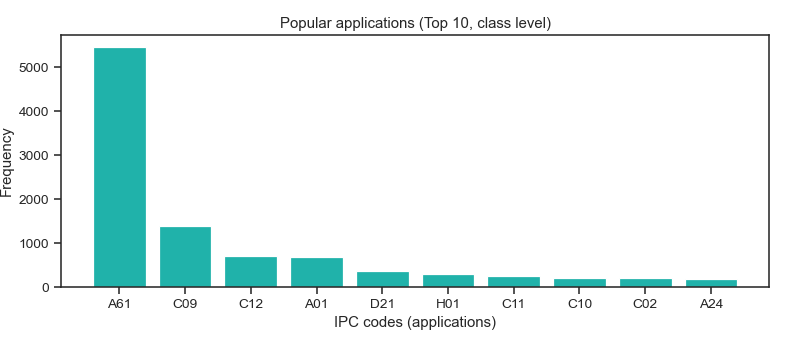

In [22]:
# Draw a bar plot showing the top 10 popular applications
plt.figure(figsize=(9,4))

x_top10_apps = [tup[0] for tup in app_count_dict_sorted[:10]]
y_counts = [tup[1] for tup in app_count_dict_sorted[:10]]

plt.bar(x=x_top10_apps, height=y_counts, color='lightseagreen')

plt.xlabel('IPC codes (applications)')
plt.ylabel('Frequency')
plt.title('Popular applications (Top 10, class level)')

plt.subplots_adjust(left=0.075, right=0.95, bottom=0.2, top=0.90)
plt.show()

A61: medical or veterinary Science, hygiene  
C09: dyes, paints, polishes, natural resins, adhesive  
C12: Biochemistry, Microbiology, Enzymology, mutation or　genetic engineering  
A01: agriculture, forestry, animal husbandry, hunting, trapping, fishing  
D21: paper-making, production of cellulose  
H01: basic electric elements  
C11: animal or vegetable oils, fats, fatty substances or waxes, detergents, candles  
C10: petroleum, gas or coke industries  
C02: treatment of water, waste water, sludge  
A24: tobacco, cigarettes, simulated smoking devices  

According to the table and plot above, medical use (A61) is the largest group as applications of biodegradable polymers (48% (5,458/11,272)). A61 is a class. In the A61 class, there are many subclasses, and under the subclasses, there are many maingroups, which explain more details. Explore the mainclasses in A61 to determine what are the popular applications in the A61 class.

### 2.5. Popular applications in the medical category (A61)

Check the popular maingroups in A61.

In [23]:
# Make a dictionary to keep an IPC code (maingroup level) as a key and the number as a value
A61_count_dict = {}

# Extract keyes having 'A61' and the values
for k, v in ipc_freq.items():
    if k[:3] == 'A61':
        ipc_maingroup = re.search('A61[A-Z] [0-9]+', k).group()
        if ipc_maingroup in A61_count_dict.keys():
            A61_count_dict[ipc_maingroup] += v
        else:
            A61_count_dict[ipc_maingroup] = v

# Sort by the frequency 
A61_count_dict_sorted = sorted(A61_count_dict.items(), key=lambda x:x[1], reverse=True)

# Show the number of maingroup
print('The number of maingroups:', len(A61_count_dict_sorted))

The number of maingroups: 86


<IPython.core.display.Javascript object>


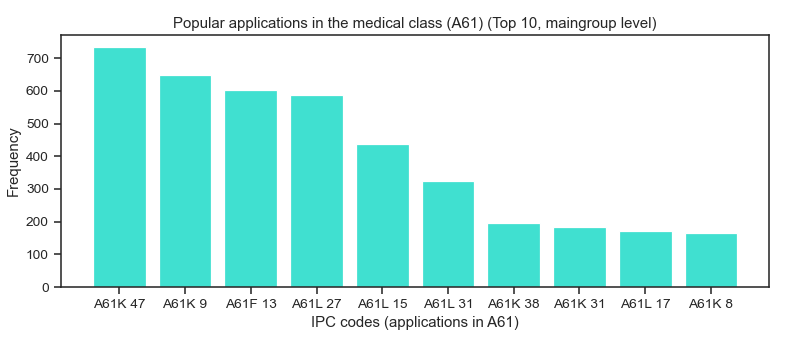

In [24]:
# Draw a bar plot showing the top 10 popular maingroups in A61
plt.figure(figsize=(9,4))

x_top10_apps_A61 = [tup[0] for tup in A61_count_dict_sorted[:10]]
y_counts = [tup[1] for tup in A61_count_dict_sorted[:10]]

plt.bar(x=x_top10_apps_A61, height=y_counts, color='turquoise')

plt.xlabel('IPC codes (applications in A61)')
plt.ylabel('Frequency')
plt.title('Popular applications in the medical class (A61) (Top 10, maingroup level)')

plt.subplots_adjust(left=0.075, right=0.95, bottom=0.2, top=0.90)
plt.show()

A61K 47: Medicinal preparations (the non-active ingredients used, e.g. carriers or inert additives), targeting or modifying agents (chemically bound to the active ingredient)    
A61K 9: Medicinal preparations (special physical form)   
A61F 13: Bandages, dressings, absorbent pads  
A61L 27: Prostheses, coating prostheses  
A61L 15: Chemical aspects of materials for bandages, dressings or absorbent pads  
A61L 31: Other surgical articles  
A61K 38: Medicinal preparations (containing peptides)  
A61K 31: Medicinal preparations (containing organic active ingredients)  
A61L 17: Surgical sutures, ligaturing blood vessels  
A61K 8: Cosmetics or toilet preparations  

'A61 47', 'A61 9', 'A61L 27', 'A61K 38', 'A61K 31', and 'A61L 17' could be used inside our body. So it makes sense that the material would be required to biodegrade in our body. 'A61F 13', 'A61L 15', 'A61L 31', and 'A61K 8' are used outside of our body. The 'biodegrade' might mean that the material biodegrades by water, bacteria, or enzyme in a natural environment.

### 2.6. Language variety

According to the first five rows of the 'df', it includes at least Spanish, Chinese, English, and Japanese. Because I'm going to use abstracts to calculate the similarities between patents, it's important to know what languages are used and the percentage of each. Remember that the 'Abstract' column has missing values. First, take a look at the rows having NaN in the "Abstract" column.

In [25]:
# Extract the patents having NaN in the "Abstract" column
df_abst_nan = df[df['Abstract'].isna()]

print('The number of patents without an abstract:', len(df_abst_nan))
print('df_abst_nan (first 2 rows):')
df_abst_nan.head(2)

The number of patents without an abstract: 578
df_abst_nan (first 2 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
46,AU236516509,2018282377,20.12.2018,AU,BIO-BASED POLYETHYLENE TEREPHTHALATE PACKAGING AND METHOD OF MAKING THEREOF,NaN,C08G 63/183; B65D 65/46; C08L 67/03; C08L 101/16; D01F 6/62,The Coca-Cola Company,NaN
74,JP293331120,2018545678,30.07.2018,JP,リグニンの製造方法,NaN,C08H 7/00; C08L 97/00; C08L 101/16,東レ株式会社,荒井 喬広; 栗原 宏征; 舩田 茂行; 山田 勝成


There are 578 patents without an abstract. At least some of them seem to have a title. It will be better to use a title as an abstract than without it. Check how many patents don't have a title nor an abstract.

In [26]:
# Extract the patents having NaN in the "Title" and "Abstract" columns
df_title_abst_nan = df_abst_nan[df_abst_nan['Title'].isna()]

print('The number of patents without a title or an abstract:', len(df_title_abst_nan))

The number of patents without a title or an abstract: 9


In [27]:
# Show the 9 patents 
print('The 9 patents without a title and abstract:')
df_title_abst_nan

The 9 patents without a title and abstract:


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
7967,US38196312,07414964,29.09.1989,US,NaN,NaN,C08G 63/91; C08G 63/84; A61K 47/48; A61K 47/48; C07F 5/00; C07F 5/00; C08G 63/00; C08G 63/08; C0...,DU PONT,STEPHAN J MCLAIN; NEVILLE E DRYSDALE
8052,GR228996259,810164951,14.05.1981,GR,NaN,NaN,A61K 9/58; A61K 9/00; A61K 9/20; A61K 9/22; A61K 9/70; A61K 31/765; A61K 47/34; A61K 47/48; C08G...,SRI INTER NATIONAL,HELLER JORGE; HELWING ROBERT FRANK; PENHALE DONALD WILLIAM HENRY
8070,GR228990772,800162846,09.09.1980,GR,NaN,NaN,C08G 63/00; A61K 9/22; A61K 47/34; C08G 63/06; C08G 63/82; C08L 101/16,ROBERT STEPHEN NEVIN,NEVIN ROBERT STEPHEN
8136,DK191243254,104575,14.03.1975,DK,NaN,NaN,C07D 253/08; A01N 43/707; A23K 1/16; A23K 1/17; C07D 253/10; C08L 101/16,CIBA GEIGY AG,DIEL P J
8137,FR187029813,7508014,14.03.1975,FR,NaN,NaN,C07D 253/08; A01N 43/707; A23K 1/16; A23K 20/195; C07D 253/10; C08L 101/16,CIBA GEIGY AG,NaN
8141,FR186821567,7503571,05.02.1975,FR,NaN,NaN,C12P 19/12; B29C 45/00; B29C 47/00; B29C 47/78; B29C 59/00; C08J 9/04; C08L 5/00; C08L 101/16,SUMITOMO CHEMICAL CO,NaN
8152,FR187764018,7425620,24.07.1974,FR,NaN,NaN,C08F 16/00; C08F 16/38; C08F 20/44; C08F 220/00; C08F 220/42; C08F 279/02; C08L 101/16,ICI LTD,NaN
8155,FR185556104,7316542,08.05.1973,FR,NaN,NaN,C08G 18/00; C08K 5/00; C08L 1/00; C08L 3/00; C08L 23/00; C08L 27/00; C08L 75/00; C08L 75/06; C08...,COLOROLL LTD,NaN
8162,FR187829230,7203573,03.02.1972,FR,NaN,NaN,B65D 1/00; B65D 25/34; B65D 65/40; C08L 61/06; C08L 97/00; C08L 97/02; C08L 101/16,BIOCOR CORP,NaN


9 patents didn't have the title nor abstract. It's 0.1% (9/8,182). I leave them as is because all of the 9 patents have many IPC codes and the IPC codes can be used to search the relationships with other patents at least.  
  
Fill the abstracts with the titles for patents having a title but not having an abstract.

In [28]:
# Make a new DataFrame to hold the data after filling the abstracts by the titles
df_with_abst = pd.DataFrame(columns=df.columns)

# Fill out the abstract with the title if the patent has a title but not an abstract. 
for i in tqdm(range(len(df))):
    df_with_abst = df_with_abst.append(df.iloc[i])
    if type(df.loc[i, 'Abstract']) == float:
        df_with_abst.loc[i, 'Abstract'] = df_with_abst.loc[i, 'Title']
        
print('df_with_abst (first 5 rows):')
df_with_abst.head()

100%|█████████████████████████████████████| 8182/8182 [00:23<00:00, 343.37it/s]

df_with_abst (first 5 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"<p id=""p-0001"" num=""0000"">A single-use, biodegradable, paper urine collector and method of using...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,"<p num="""">【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。<br/>【手段】疎水性成分と親水...",C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


According to exploring the abstracts, some HTML tags and line feed codes ('\n') are included in abstracts. They can be an obstacle to identify the languages. Remove them before identifying what kind of languages are used.

In [29]:
# Remove HTML tags and line feed codes 
for i in range(len(df_with_abst)):
    if type(df_with_abst.loc[i, 'Abstract']) == str:
        # Remove HTML tags
        text = re.sub(r'<.+?>', '', df_with_abst.loc[i, 'Abstract'])
        
        # Remove '\n' 
        df_with_abst.loc[i, 'Abstract'] = text.replace('\n', '')

print('After removing HTML tags and line feed codes')
print('df_with_abst (first 5 rows):')
df_with_abst.head()

After removing HTML tags and line feed codes
df_with_abst (first 5 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红
2,CN283956286,201911046573.7,30.10.2019,CN,一种易降解环保的塑料材料,本发明公开了一种易降解环保的塑料材料及其制备方法，其原料按重量份包括有：聚乙烯20‑30份、聚烯烃共聚物15‑18份、生物降解塑料20‑25份、琼脂5‑8份、聚醇类化合物10‑15份和天然高分...,C08L 23/06; C08L 101/16; C08L 23/02; C08L 5/12; C08L 71/00; C08L 5/00; C08L 77/00,河南晖睿智能科技有限公司,李耀峰; 王莹; 刘志杰; 陈平绪; 周光灿; 李霞; 张凯强
3,US293704217,16657809,18.10.2019,US,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector...",A61B 10/00; G01N 33/493; C08L 101/16; B67C 11/00,Abigail Ford MOORE,Abigail Ford MOORE
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。【手段】疎水性成分と親水性成分との共重合体である脂肪族...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望


Here, a [language identification model](https://fasttext.cc/docs/en/language-identification.html) by [fastText](https://fasttext.cc/) is used to identify the languages of abstracts. FastText is a library developed by Facebook. The pre-trained model ('lid.176.bin') predicts the language used in a given text. It can recognize 176 languages.  
  
The function `predict_language` predicts the language of a given text. If the result is more than 70% sure, the predicted language is returned, and if it is less than 70%, 'unsure' is returned. Here, I chose 70% as a cut-off point because of the balance between the accuracy and the number of 'unsure.' The accuracy is still very good at 70% (you will see it later.)

In [30]:
# Define a function predicting the language
def predict_language(text):
    '''identify language, and return it if it is more than 70% sure'''
    
    # Lower the text
    text = text.lower()
    
    # Predict language
    label, prob = li_model.predict(text)
    
    # Return the language if more than 70% sure
    if prob > 0.7:
        return label[0].replace("__label__", "")
    else:
        return 'unsure'

In [31]:
# Make a new column to store the predicted languages
df_with_abst['Language'] = ''

# Predict the languages
for i in range(len(df_with_abst)):
    if type(df_with_abst.loc[i, 'Abstract']) == float:
        df_with_abst.loc[i, 'Language'] = 'no abstract'
    else:
        language = predict_language(df_with_abst.loc[i, 'Abstract'])
        df_with_abst.loc[i, 'Language'] = language
            
print('df_with_abst (first 2 rows):')
df_with_abst.head(2)

df_with_abst (first 2 rows):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
0,AR192047768,P150101734,01.06.2020,AR,COMPOSICIÓN POLIMÉRICA RELLENA CON UNA MEZCLA DE MATERIAL DE CARGA INORGÁNICO,"La presente se refiere a una composición polimérica que comprende por lo menos 20,0% en peso, en...",C08L 67/02; C08L 67/04; C08L 101/16,OMYA INTERNATIONAL AG,NaN,es
1,CN291905122,201911284939.4,13.12.2019,CN,一种环保型塑料材料及其制备方法,本发明公开了一种环保型塑料材料，按照质量百分比由以下组分组成：共聚型聚丙烯5％～12％，抗氧剂7％～11％，竹纤维素8％～13％，聚乙烯醇6％～10％，无碱玻璃纤维5％～8％，其余为可降解塑料...,C08L 101/16; C08L 23/14; C08L 1/02; C08L 29/04; C08K 7/14,陕西速源节能科技有限公司,贺红,zh


Check if the languages were correctly identified. 100 datapoints are randomly selected from the dataframe using the following codes. Then, I check the accuracy by hand.

In [32]:
# Error analysis
# Extract 100 random samples from df_with_abst
df_accuracy_check = df_with_abst.sample(n=100, random_state=1)[['Patent_Id', 'Country', 'Abstract', 'Language']]

In [33]:
# Please change the numbers inside iloc[] to check the accuracy
print('Random samples from df_with_abst:')
df_accuracy_check.iloc[90:]

Random samples from df_with_abst:


,Patent_Id,Country,Abstract,Language
1681,JP273410613,JP,工程（ａ）から（ｃ）を含むポリラクチドフィルムの形成方法。工程（ａ）では、剥離剤コーティングを備える処理されたツール表面が提供される。この処理されたツール表面は、ポリラクチドのガラス転移温...,ja
5340,JP269633797,JP,PROBLEM TO BE SOLVED: To provide a new polymer useful as a polymer surface-active agent or an em...,en
6233,JP268554415,JP,PROBLEM TO BE SOLVED: To obtain a flame-retarded composition excellent in workability on a sheet...,en
4029,WO2005059014,WO,"A biodegradable foam that excels in biodegradability, moldability and heat resistance and that e...",en
2774,JP271756167,JP,PROBLEM TO BE SOLVED: To provide a biomass derived fiber reinforced flame-retardant resin compos...,en
2270,JP272273207,JP,PROBLEM TO BE SOLVED: To provide a method for producing a new and useful biodegradable resin com...,en
3390,JP271278925,JP,PROBLEM TO BE SOLVED: To obtain a resin composition having a low environmental load that excels ...,en
3125,JP272189887,JP,新規な生分解性リン酸エステルポリアミンを開示する。この生分解性リン酸エステルポリアミンは、組織の接着剤または封止剤として使用することができる吹付可能組成物のための架橋剤として利用することができ...,ja
8041,EP11519558,EP,BIORESORBABLE POLYESTERS AND POLYESTER COMPOSITES,unsure
4356,BR6308693,BR,"""PROCESSO DE FABRICAçãO DE MOLDAGEM DE CELULOSE, APARELHO DE EXTRAçãO DE COMPONENTE DE PLANTA E ...",pt


The accuracy was 100% at the 100 random samples. Next, check the number of datapoints having NaN in the abstract and the number of patents in which the language is not sure.

In [34]:
print('The numebr of patents having NaN in the abstract:', len(df_with_abst[df_with_abst['Language'] == 'no abstract']))
print('The number of patents in which the language is not sure:', len(df_with_abst[df_with_abst['Language'] == 'unsure']))

The numebr of patents having NaN in the abstract: 9
The number of patents in which the language is not sure: 130


The 9 patents were already discussed. They do not have a title nor an abstract. 130 (1.6%) patents had a low prediction rate. Check them and identify the language by hand.

In [35]:
# Extract the patents which language is 'unsure' 
df_unsure_language = df_with_abst[df_with_abst['Language'] == 'unsure'][['Patent_Id', 'Country', 'Abstract', 'Language']]

print('df_unsure_language (first 5 rows):')
df_unsure_language.head()

df_unsure_language (first 5 rows):


,Patent_Id,Country,Abstract,Language
77,WO2019022502,WO,"Provided are: a method for preparing biodegradable polymer microparticles and, particularly, por...",unsure
906,EP254727492,EP,BIODEGRADABLE POLYMERIC NANOCOMPOSITE MATERIALS AND APPLICATIONS OF THE SAME,unsure
987,PT232813269,PT,BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL,unsure
988,PT278275348,PT,BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL,unsure
991,ES105853532,ES,Contenedor biodegradable para inóculos fúngicos,unsure


Each patent has a 'Country' column. It will be connected to the language kind of the patent. For example, when a patent is registered in a country in which an official language is English, the patent would be written in English. First, check the country variety in df_unsure_language.

In [36]:
# Show the unique values in the 'Country' column
print('The unique values in the "Country" column:')
df_unsure_language['Country'].unique()

The unique values in the "Country" column:


array(['WO', 'EP', 'PT', 'ES', 'JP', 'ID', 'US', 'BR', 'EE', 'IT', 'GR',
       'PH', 'AU', 'AR', 'NZ', 'RO', 'DK', 'GB', 'SE'], dtype=object)

Some countries in the list use English as an official language: US (America), PH (Philippines), AU (Australia), 'NZ (New Zealand), and GB (United Kingdom). Also, WO (WIPO, World Intellectual Property Organization) and EP (EPO, European Patent Office) use English for their publications. The patents from the countries and organizations should be written in English. I have decided to label them as 'en'. Then, check the languages of rest of the patents. 

In [37]:
# Make a list of the countries in which English is used as an official language 
english_countries_list = ['WO', 'US', 'PH', 'AU', 'NZ', 'EP', 'GB']

# Countries in which English is not used as the first language 
non_english_countries_set = set(df_unsure_language['Country'].unique()) - set(english_countries_list)

# Check the language by hand
print('Show the abstracts having a country code of non-English country to identify the languages:')
for country in non_english_countries_set:
    print('-------------------------------------------------------------------------')
    print('Country code:', country)
    print(df_unsure_language[df_unsure_language['Country'] == country]['Abstract'])

Show the abstracts having a country code of non-English country to identify the languages:
-------------------------------------------------------------------------
Country code: RO
7757    BIODEGRADABLE POLYMERS
Name: Abstract, dtype: object
-------------------------------------------------------------------------
Country code: PT
987                                  BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL
988                                  BIODEGRADABLE MATERIAL AND METHOD FOR PRODUCING BIODEGRADABLE MATERIAL
6046                                                                       IMPLANTES BIOLOGICAMENTE ACTIVOS
7743    PROCESSO PARA A PREPARACAO DE PAPEL A BASE DE POLPA DE CELULOSE COM AS FIBRAS LIGADAS COM RESINA...
7770         PROCESSO PARA A PREPARACAO DE PARTICULAS PARA A LIBERTACAO CONTROLADA DE UM INGREDIENTE ACTIVO
7784    PROCESSO PARA A PREPARACAO DE UM COPOLIMERO ABSORVIVEL SEGMENTADO OBTIDO A PARTIR DE MONOMEROS D...
7786    PROCESSO P

In [38]:
# Identify the language of each country code from the table above
country_language_dict = {'ES':'es', 'IT':'it', 'ID':'id', 'EE':'et', 'BR':'pt', 'DK':'da', 'JP':'ja', 'RO':'en', 'SE':'sv',
                    'PT':'pt', 'AR':'es', 'GR':'en'}

# Make a dictionary for exceptional patents
index_language_dict = {987:'en', 988:'en', 8054:'en', 3738:'en', 4305:'en'}

# Assign the new labels
for i in range(len(df_with_abst)):
    if df_with_abst.loc[i, 'Language'] == 'unsure':
        if df_with_abst.loc[i, 'Country'] in english_countries_list:
            df_with_abst.loc[i, 'Language'] = 'en'
            
        else:    
            df_with_abst.loc[i, 'Language'] = country_language_dict[df_with_abst.loc[i, 'Country']]
            if i in index_language_dict.keys():
                df_with_abst.loc[i, 'Language'] = index_language_dict[i]

print('The numebr of patents having NaN in the abstract:', len(df_with_abst[df_with_abst['Language'] == 'no abstract']))
print('The number of patents in which the language is not sure:', len(df_with_abst[df_with_abst['Language'] == 'unsure']))

The numebr of patents having NaN in the abstract: 9
The number of patents in which the language is not sure: 0


Now all patents have a language label in the 'Language' column except for the 9 patents. Check the top 5 languages.

In [39]:
# Make a dictionary showing the languages and the frequencies 
language_count_dict = df_with_abst['Language'].value_counts().to_dict()

# Make a DataFrame of top 5 applications
df_language_count = pd.DataFrame(data={'Language code':list(language_count_dict.keys()), 
                                   'Count':list(language_count_dict.values())})
# Show the top 5 languages
print('The number of language kinds:', len(language_count_dict))
print('Top 5 languages:')
df_language_count.head()

The number of language kinds: 19
Top 5 languages:


,Language code,Count
0,en,6687
1,ja,799
2,es,237
3,pt,184
4,ko,59


81.7% (6687/8182) of the abstracts is written in English. The accuracy of the language identification was already checked, but check it again after removing English abstracts so that we can see the rest of them enough.

In [40]:
# Error analysis
# Extract non-English rows
df_with_abst_except_en = df_with_abst[df_with_abst['Language'] != 'en']
df_accuracy_check2 = df_with_abst_except_en.sample(n=100, random_state=1)[['Patent_Id', 'Country', 'Abstract', 'Language']]

In [41]:
# Please change the numbers inside iloc[] to check the accuracy
df_accuracy_check2.iloc[95:100]

,Patent_Id,Country,Abstract,Language
5477,JP269947872,JP,酵素合成アミロースから得られる生分解性物品,ja
3010,ES144955331,ES,"Composición de plástico biodegradable, artículo moldeado a partir de la composición y método par...",es
5374,BR6275281,BR,"""COPOLìMEROS BIODEGRADáVEIS DE POLIHIDROXIALCANOATO COM PROPRIEDADES MELHORADAS DE CRISTALIZAçãO...",pt
1559,JP272882062,JP,【課題】ポリエステルポリオール由来のポリウレタンとしての特性である耐熱、耐候性、耐水性を維持したまま、地球環境に優しく、ポリウレタン反応の制御がし易く、更にポリウレタンの伸度や弾性率の優れたポ...,ja
7762,JP265774282,JP,【構成】 下記の３成分（Ａ）～（Ｃ）を主成分とする プリント基板マスキングテープ用硬化性組成物； （...,ja


The accuracy was 100% at the 100 randam samples again. I assume the other datapoints are also accurate. Draw the plot of the language variety. 

<IPython.core.display.Javascript object>


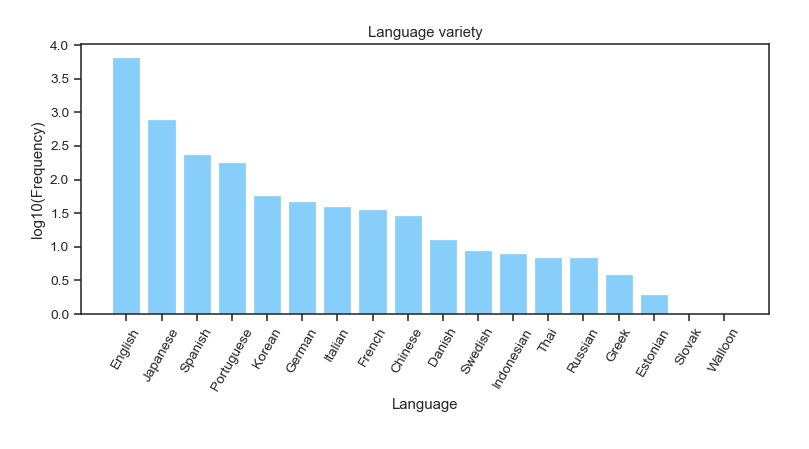

In [42]:
# Remove 'no abstract' from language_count_dict to draw a plot
language_count_dict.pop('no abstract')

# Draw a bar plot of the language variety
plt.figure(figsize=(9,5))

# Exchange the abbriviations into the full names (using a iso_language_codes library)
x_languages = [language_name(lan) for lan in language_count_dict.keys()]

# Transform the counts into logarithm 
y_counts = [np.log10(val) for val in language_count_dict.values()]

plt.bar(x_languages, y_counts, color='lightskyblue')

plt.xlabel('Language')
plt.ylabel('log10(Frequency)')
plt.title('Language variety')

plt.xticks(rotation=60)

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.3, top=0.90)
plt.show()

81.7% (6,687/8,182) of the abstracts is written in English. 9.8% (799/8,182) is written in Japanese. The abstracts in English and Japanese will be used to calculate the similarity of patents because I can understand the two languages. On the other hand, the IPC codes can be used to analyze the relationships even if a patent is written in other languages. So I'll keep them too. 

## 3. Data Wrangling  

The purpose of this section is to make the data ready for modeling. I deal with the 'Abstract' column to prepare for calculating the similarities between patents.

3.1. Translate Japanese to English  
3.2. Tokenization  
3.3. Clean up tokens   
3.4. Adjust the number of tokens per patent

### 3.1. Translate Japanese to English

9.8% of the abstracts was written in Japanese. Here, translate those abstracts into English to use them to calculate the similarities between patents.

In [43]:
# Extract patents having Japanese abstracts
df_ja_abst = df_with_abst[df_with_abst['Language'] == 'ja']

print('df_ja_abst (first row):')
df_ja_abst.head(1)

df_ja_abst (first row):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。【手段】疎水性成分と親水性成分との共重合体である脂肪族...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja


In [44]:
# Check the abstracts
print('Randomly sampled Japanese abstracts:')
print('See several abstracts to check the formats.')
df_ja_abst['Abstract'].sample(5)

Randomly sampled Japanese abstracts:
See several abstracts to check the formats.


7712                                                                                                  抗菌性樹脂
524     容器内でアルコールモノマーと水溶液を混合し、酸モノマーを容器に加え、容器から水を除去し、そして容器からポリマー材料を生成させることを含み、ポリマー材料はアルコールモノマーと酸モノマーのポリエス...
1405    本発明は、最適な柔軟性を示すだけでなく、耐熱性を含む諸般物性に優れて、包装用材料として有用に使用され得るポリ乳酸樹脂およびこれを含む包装用フィルムに関する。  前記ポリ乳酸樹脂は、所定のポリ乳...
2235      本発明は、脂肪族ジカルボン酸または脂肪族ジカルボン酸および芳香族ジカルボン酸ならびにジヒドロキシ化合物を基礎とする生物学的に分解可能なポリエステルを連続的に製造する方法に関し、この場合脂肪...
4       【課題】生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。【手段】疎水性成分と親水性成分との共重合体である脂肪族...
Name: Abstract, dtype: object

The abstracts have a format. Each abstract has '【課題】'(problem) and '【解決手段】'(means for solving the problems).They are a title of the following sentenses. Also, the expressions after '【選択図】' (figure) mean the explanation about the figure originally included in the database. Remove them.

In [45]:
# Copy df_ja_abst
df_ja_abst_withoutTitles = df_ja_abst.copy()

# Remove titles 
for i in range(len(df_ja_abst)):
    
    # Remove '【選択図\】' plus a following number
    text = re.sub(r'\【選択図\】.*', '', df_ja_abst.loc[df_ja_abst.index[i], 'Abstract'])
    
    # Remove titles
    df_ja_abst_withoutTitles.loc[df_ja_abst_withoutTitles.index[i], 'Abstract'] = re.sub(r'\【.+?\】', '', text)

print('df_ja_abst (first row)(after removing the titles):')
df_ja_abst_withoutTitles.head(1)

df_ja_abst (first row)(after removing the titles):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであ...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja


In [46]:
# Take a look at the full abstract of the first patent
print('The full abstract of the first patent:')
df_ja_abst_withoutTitles.iloc[0, df_ja_abst_withoutTitles.columns.get_loc('Abstract')]

The full abstract of the first patent:


'生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであって、該親水性成分が、ポリ（１，５−ジオキセパン−２−オン）、ポリ（１，４−ジオキサン−２−オン）、または、ポリエチレンオキシドの少なくとも１つを含み、該親水性成分のモル比が５％以上８５％以下である、抗血小板粘着性を示す生分解性共重合体。'

They have been removed. Next, translate Japanese to English. Here, I use a translation library called [googletrans](https://py-googletrans.readthedocs.io/en/latest/), which is developed by Google. It is free, but there is a restriction that is a maximum of 15k words in 24 hours from one IP address. I divide df_ja_abst_withoutTitles into two part so that each of them has less than 15k words. (If you want to avoid the restriction, there is a [paid version](https://cloud.google.com/translate/docs).) I save the DataFrame with the translated abstracts as a CSV file. If you need it, go to 4 more cells from here. 

In [47]:
#  Make a new column to store translated abstracts
df_ja_abst_withoutTitles = df_ja_abst_withoutTitles.assign(Translated_Abstract = '')

# Copy df_ja_abst_withoutTitles
df_ja_abst_translated = df_ja_abst_withoutTitles.copy()

# The first half
# Translate Japanese abstracts into English (using googletrans)
for i in tqdm(range(400)):
    # Generate a translator 
    translator = Translator()

    # Translate the sentences of the 'Abstract' column 
    en_text = translator.translate(df_ja_abst_withoutTitles.loc[df_ja_abst_withoutTitles.index[i], 'Abstract'])
    
    # Store them in the 'Translated Abstract' column
    df_ja_abst_translated.loc[df_ja_abst_translated.index[i], 'Translated_Abstract'] = en_text.text

100%|████████████████████████████████████████| 400/400 [04:07<00:00,  1.62it/s]


In [49]:
# The second half
# Translate Japanese abstracts into English
for i in tqdm(range(400, len(df_ja_abst_withoutTitles))):
    # Generate a translator (googletrans)
    translator = Translator()

    # Translate the sentences of the 'Abstract' column 
    en_text = translator.translate(df_ja_abst_withoutTitles.loc[df_ja_abst_withoutTitles.index[i], 'Abstract'])
    
    # Store them in the 'Translated Abstract' column
    df_ja_abst_translated.loc[df_ja_abst_translated.index[i], 'Translated_Abstract'] = en_text.text
    
print('df_ja_abst_translated (first row):')
df_ja_abst_translated.head(1)  

100%|████████████████████████████████████████| 399/399 [03:26<00:00,  1.93it/s]

df_ja_abst_translated (first row):


,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors,Language,Translated_Abstract
4,JP293331568,2019174742,25.09.2019,JP,抗血小板粘着性を示す生分解性共重合体,生分解性と抗血栓性とを併せ持ち、また、形状安定性に優れた、これまでにない新規構造の抗血小板粘着性を示す生分解性共重合体を提供する。疎水性成分と親水性成分との共重合体である脂肪族ポリエスエルであ...,C08G 63/08; A61L 27/34; A61L 27/40; A61L 27/58; A61L 29/08; A61L 29/12; A61L 29/14; A61L 31/10; ...,国立大学法人秋田大学,寺境 光俊; 松本 和也; 廣川 誠; 植木 重治; 柏谷 啓太; 竹田 麻央; 工藤 滉平; 福岡 玲; 疋田 正喜; 齋藤 希望,ja,"It combines the biodegradability and antithrombotic, also excellent in shape stability, to provi..."


In [ ]:
# Save the dataframe as a csv file
df_ja_abst_translated.to_csv('df_ja_abst_translated.csv')

In [51]:
# If you need the result (df_ja_abst_translated)
# Load the CSV file 
df_ja_abst_translated_file = 'df_ja_abst_translated.csv'
df_ja_abst_translated = pd.read_csv(df_ja_abst_translated_file, index_col=0)

Check if the translation is right. Randomly extract 80 samples (rows) from df_ja_abst_translated, and check the accuracy.

In [52]:
# Error analysis: take a look at 80 samples of the translated sentenses to identify the translation was right 
# Extract 80 random samples
df_accuracy_check3 = df_ja_abst_translated.sample(n=80)[['Patent_Id', 'Abstract', 'Translated_Abstract']]

In [53]:
# Please change the numbers inside iloc[] to check the accuracy (from 0 to 80)
pd.set_option("display.max_colwidth", 1000)
df_accuracy_check3.iloc[78:80]

,Patent_Id,Abstract,Translated_Abstract
5040,JP270338264,本発明はｐＨ４以上の水溶液でミセルを形成しうる、１個の末端カルボキシル基を有するポリ乳酸誘導体に関する。上記ミセル内部に難溶性薬物を含有できるので多様な形態のドラッグデリバリーシステムとしての応用が可能である。,"The present invention can form micelles in pH4 more aqueous solutions, regarding polylactic acid derivative having one terminal carboxyl group. Because it contains a poorly soluble drug inside the micelle it is applicable as a drug delivery system of a variety of forms."
4224,JP271089404,α－１，４－グルカンおよび／またはその修飾物を含む成型物およびその製造方法,"Molding and methods of manufacturing including alpha-1,4-glucan and / or modifications thereof"


Sometimes the translations were not straightforward, but the meanings were mostly fine. I assume the rest of the translations are also accurate.

### 3.2. Tokenization 

In this section, I separate the sentences into words to use them for a sentence similarity calculation. First, extract English patents, and take care of the format.  

In [54]:
# Create a new DataFrame to store patents having an English abstract
df_en_abst = pd.DataFrame(columns=['Patent_Id', 'Title', 'Abstract'])

# Extract rows having an English abstract
for i in tqdm(range(len(df_with_abst))):
    if df_with_abst.loc[df_with_abst.index[i], 'Language'] == 'en':
        # Extract rows having an English anstract
        df_en_abst = df_en_abst.append(df_with_abst.loc[df_with_abst.index[i], ['Patent_Id', 'Title', 'Abstract']])
        
print('The number of patents with an English abstract:', len(df_en_abst))

100%|█████████████████████████████████████| 8182/8182 [00:16<00:00, 502.79it/s]

The number of patents with an English abstract: 6687


In [55]:
# Check the abstracts by sampling the data (try several times to check the formats)
print('Some samples from df_en_abst:')
df_en_abst.sample(2)

Some samples from df_en_abst:


,Patent_Id,Title,Abstract
5499,JP269348746,MOLDING SOLUTION OF BIODEGRADABLE SYNTHETIC RESIN AND METHOD FOR PRODUCING MOLDED PRODUCT USING THE SAME,"PROBLEM TO BE SOLVED: To provide a molding resin solution of a biodegradable synthetic resin capable of efficiently producing a biodegradable synthetic resin molded product which has good structural uniformity, has high durability to temperature changes, is excellent in mechanical strength, and therefore is high quality, and to provide a method for producing the biodegradable synthetic resin molded product by using the resin solution. SOLUTION: This molding resin solution of biodegradable synthetic resin (a so-called 'casting resin') is produced by adding a compatibilizer having a function of finely pulverized molecular crystals to the solution and dispersing acetyl cellulose and a biodegradable resin in a common solvent so as to form a micro-structural state. The molded product is produced by using the molding resin solution.COPYRIGHT: (C)2003,JPO"
3427,JP271252056,BIODEGRADABLE GLOVE,"PROBLEM TO BE SOLVED: To provide a biodegradable glove to be especially used for artificial insemination or rectal palpation of cow and horse, excellent in flexibility and film strength, and having elongation in the longitudinal direction to the glove and low tension load in a low elongation area.SOLUTION: The biodegradable glove is made of a biodegradable polyester resin film. The biodegradable polyester resin film contains an aromatic-aliphatic polyester and an aliphatic polyester at a weight ratio of (95:5)-(40:60). The film has an elongation at break of 500% in the longitudinal direction to the glove and 50% tension load of 15 MPa.COPYRIGHT: (C)2008,JPO&INPIT"


Some abstracts have a format. Some patens published in Russia have 'FIELD:', 'SUBSTANCE:', and 'EFFECT:.' Some patents published in Japan have 'PROBLEM TO BE SOLVED:' and 'SOLUTION:'. They are the title of the following sentences. Also, the expressions after 'SELECTED DRAWING:' mean the explanation about the figure originally included in the database, and the expressions after 'COPYRIGHT:' are about copyright. Some patents have 'PURPOSE:' and ' CONSTITUTION:'. They are not needed. Remove them.

In [56]:
# Remove titles 
for i in range(len(df_en_abst)):
    
    # Remove 'SELECTED DRAWING:' plus the following words
    text = re.sub(r'SELECTED DRAWING:.*', '', df_en_abst.loc[df_en_abst.index[i], 'Abstract'])
    
    # Remove 'COPYRIGHT:' plus the following words
    text = re.sub(r'COPYRIGHT:.*', '', text)
    
    # Remove titles
    text = re.sub(r'FIELD:', '', text)
    text = re.sub(r'SUBSTANCE:', '', text)
    text = re.sub(r'EFFECT:', '', text)
    text = re.sub(r'PROBLEM TO BE SOLVED:', '', text)
    df_en_abst.loc[df_en_abst.index[i], 'Abstract'] = re.sub(r'SOLUTION:', '', text)

print('df_en_abst (first two rows) (after removing the titles):')
df_en_abst.head(2)

df_en_abst (first two rows) (after removing the titles):


,Patent_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector including a funnel body having a sloped continuous sidewall, a sloped base, a top opening, a funnel hole located at the lowest region of the sloped base and, optionally, a urine sample container operatively coupled to the sloped base. To convey funneled urine into the container, a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body. The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole."
5,WO2020059793,RESIN MOLDED ARTICLE AND METHOD FOR PRODUCING SAME,"A resin molded article and a method for producing the same, the resin molded article having an interlayer molding obtained by molding a resin including a thermoplastic water-soluble polymer, and at least one shielding layer for shielding the entire outer periphery of the interlayer molding from the external environment, the occurrence of microplastic from the resin molded article being suppressed, the persistence of microplastic discharged into the ocean, etc., from the resin molded article being reduced, and there being no risk of adverse effects on the natural environment from the resin molded article."


Next, concatenate df_en_abst and df_ja_abst_translated to prepare for tokenization.

In [57]:
# Extract 'Patent_Id', 'Title', and 'Translated_Abstract' columns from df_ja_abst_translated
df_ja_abst_extracted = df_ja_abst_translated[['Patent_Id', 'Title', 'Translated_Abstract']]

# Rename the column
df_ja_abst_extracted = df_ja_abst_extracted.rename(columns={'Translated_Abstract': 'Abstract'})

# Merge df_en_abst and df_ja_abst_extracted
df_enja_abst = df_en_abst.append(df_ja_abst_extracted).sort_index()

print('The number of rows of df_enja_abst:', len(df_enja_abst))
print('df_enja_abst (first two rows):')
df_enja_abst.head(2)

The number of rows of df_enja_abst: 7486
df_enja_abst (first two rows):


,Patent_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,"A single-use, biodegradable, paper urine collector and method of using same, the urine collector including a funnel body having a sloped continuous sidewall, a sloped base, a top opening, a funnel hole located at the lowest region of the sloped base and, optionally, a urine sample container operatively coupled to the sloped base. To convey funneled urine into the container, a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body. The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole."
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,"It combines the biodegradability and antithrombotic, also excellent in shape stability, to provide a biodegradable copolymer to exhibit anti-platelet adhesion of the novel structure unprecedented. An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component, the hydrophilic component is poly (1,5-dioxepan-2-one), poly (1,4-dioxan-2 on), or comprises at least one of polyethylene oxide, the molar ratio of the hydrophilic component is 85% or less than 5%, the raw shows the anti-platelet adhesion degradable copolymer."


Compound names generally have numbers and punctuations (e.g., poly (1,5-dioxepan-2-one)). Because I would like to remain the sets of numbers and structure names, remove the punctuations before the tokenization. 

In [58]:
# Remove punctuations (using 'string' library)
df_enja_abst_noPunc = df_enja_abst.copy()

for i in tqdm(range(len(df_enja_abst_noPunc))):
    
    abst = df_enja_abst_noPunc.loc[df_enja_abst_noPunc.index[i], 'Abstract']
    # Remove punctuations
    df_enja_abst_noPunc.loc[df_enja_abst_noPunc.index[i], 'Abstract'] = abst.translate(str.maketrans('', '', string.punctuation))

print('df_enja_abst_noPunc (first 2 rows):')
df_enja_abst_noPunc.head(2)

100%|████████████████████████████████████| 7486/7486 [00:01<00:00, 5953.95it/s]

df_enja_abst_noPunc (first 2 rows):


,Patent_Id,Title,Abstract
3,US293704217,BIODEGRADABLE URINE COLLECTOR,A singleuse biodegradable paper urine collector and method of using same the urine collector including a funnel body having a sloped continuous sidewall a sloped base a top opening a funnel hole located at the lowest region of the sloped base and optionally a urine sample container operatively coupled to the sloped base To convey funneled urine into the container a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,It combines the biodegradability and antithrombotic also excellent in shape stability to provide a biodegradable copolymer to exhibit antiplatelet adhesion of the novel structure unprecedented An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component the hydrophilic component is poly 15dioxepan2one poly 14dioxan2 on or comprises at least one of polyethylene oxide the molar ratio of the hydrophilic component is 85 or less than 5 the raw shows the antiplatelet adhesion degradable copolymer


See the second row. 'Poly (1,5-dioxepan-2-one)' became 'poly 15dioxepan2one.' If tokenization were implemented without removing punctuations, the compound name would be tokenized into 'poly', '1', '5', 'dioxepan', '2', and 'one'. The features are divided into many tokens and it is difficult for a prediction model to identify the tokens as the compound name unless using a hexagram. By removing punctuations before tokenization, the compound is recognizable as a bigram.

Now, 91.5% (7,486/8,182) of the patents in the data have an English abstract. They will be used to calculate the similarities between patents. Next, tokenize the abstracts in df_enja_abst_noPunc.

In [59]:
# Make a list from df_enja_abst_noPunc['Abstract']
abst_list = list(df_enja_abst_noPunc['Abstract'])

# Tokenize the abstracts
tokens_list = [nltk.word_tokenize(abst) for abst in abst_list] 

# How many unique words?
before_word_number = len(set(token for abst in tokens_list for token in abst))

print('Number of unique tokens:', before_word_number)
print("tokens_list (several tokens of the second patent):")
tokens_list[1][25:45]

Number of unique tokens: 22500
tokens_list (several tokens of the second patent):


['An',
 'aliphatic',
 'Poriesueru',
 'a',
 'copolymer',
 'of',
 'a',
 'hydrophobic',
 'component',
 'and',
 'a',
 'hydrophilic',
 'component',
 'the',
 'hydrophilic',
 'component',
 'is',
 'poly',
 '15dioxepan2one',
 'poly']

### 3.3. Clean up tokens

In this section, tokens that are not useful to calculate the similarities are removed, and tokens are standardized to the base forms. 

3.3.1. Lower the case  
3.3.2. Remove stop words   
3.3.3. Remove numbers  
3.3.4. Stemming  
3.3.5. Frequent words

#### 3.3.1. Lower the case

First, lower the case.

In [60]:
# Lower the case
tokens_lower_list = [[token.lower() for token in abst] for abst in tokens_list]

print("tokens_lower_list (several tokens of the second patent):")
tokens_lower_list[1][25:45]

tokens_lower_list (several tokens of the second patent):


['an',
 'aliphatic',
 'poriesueru',
 'a',
 'copolymer',
 'of',
 'a',
 'hydrophobic',
 'component',
 'and',
 'a',
 'hydrophilic',
 'component',
 'the',
 'hydrophilic',
 'component',
 'is',
 'poly',
 '15dioxepan2one',
 'poly']

#### 3.3.2. Remove stop words

Also, stop words have less information about a patent. Remove stop words.

In [61]:
# Remove all stop words
cached_stop_words = stopwords.words('english')
tokens_noStop_list = [[token for token in abst if token not in cached_stop_words] 
                      for abst in tokens_lower_list]

print("tokens_nostop_list (several tokens of the second patent):")
tokens_noStop_list[1][25:45]

tokens_nostop_list (several tokens of the second patent):


['poly',
 '15dioxepan2one',
 'poly',
 '14dioxan2',
 'comprises',
 'least',
 'one',
 'polyethylene',
 'oxide',
 'molar',
 'ratio',
 'hydrophilic',
 'component',
 '85',
 'less',
 '5',
 'raw',
 'shows',
 'antiplatelet',
 'adhesion']

#### 3.3.3. Remove numbers

Numbers can be included frequently. In this project, I decided to remove them to reduce complexity. However, compound names are combinations of numbers and alphabets. Here, let's remove tokens having only numbers.

In [62]:
# Remove numbers
tokens_noNum_list = [[token for token in abst if not token.isnumeric()] for abst in tokens_noStop_list]

print("tokens_noNum_list (several tokens of the second patent):")
tokens_noNum_list[1][25:45]

tokens_noNum_list (several tokens of the second patent):


['poly',
 '15dioxepan2one',
 'poly',
 '14dioxan2',
 'comprises',
 'least',
 'one',
 'polyethylene',
 'oxide',
 'molar',
 'ratio',
 'hydrophilic',
 'component',
 'less',
 'raw',
 'shows',
 'antiplatelet',
 'adhesion',
 'degradable',
 'copolymer']

#### 3.3.4. Stemming

English words change the form depending on the context. To reduce inflected words to their word stem (or root) form, stemming are used.

In [63]:
# Stemming by Snowball stemmer
snowball = SnowballStemmer(language='english')
tokens_stem_list = [[snowball.stem(token) for token in abst] for abst in tokens_noNum_list]

print("tokens_stem_list (first 12 tokens of the first patent):")
tokens_stem_list[1][25:45]

tokens_stem_list (first 12 tokens of the first patent):


['poli',
 '15dioxepan2on',
 'poli',
 '14dioxan2',
 'compris',
 'least',
 'one',
 'polyethylen',
 'oxid',
 'molar',
 'ratio',
 'hydrophil',
 'compon',
 'less',
 'raw',
 'show',
 'antiplatelet',
 'adhes',
 'degrad',
 'copolym']

In [64]:
# How many unique words?
stem_word_number = len(set(token for abst in tokens_stem_list for token in abst))

print('Number of tokens removed:', before_word_number - stem_word_number)
print('Current number of unique tokens:', stem_word_number)

Number of tokens removed: 8013
Current number of unique tokens: 14487


#### 3.3.5. Frequent words

Show the frequent words.

In [65]:
# Count the number of each word 
words_list_after = [token for abst in tokens_stem_list for token in abst]
frequency_after = nltk.FreqDist(words_list_after)

# Sort the dictionary
frequency_after_sorted = dict(sorted(frequency_after.items(), key=lambda w: w[1]))

<IPython.core.display.Javascript object>


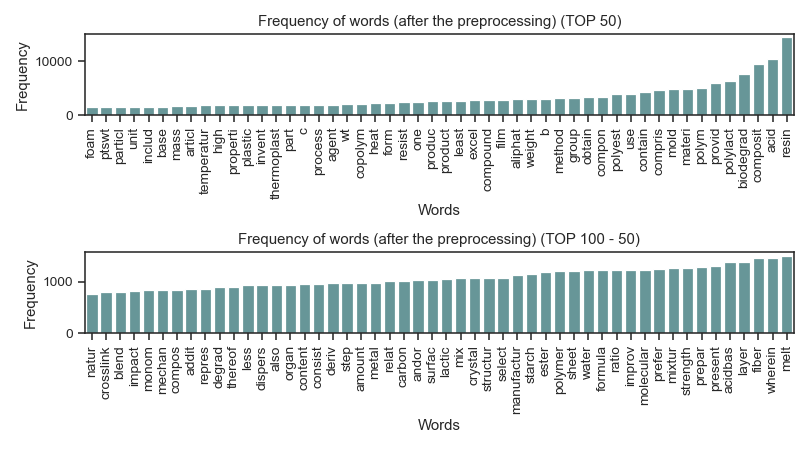

In [66]:
# Create a plot
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
sns.barplot(x=list(frequency_after_sorted.keys())[-50:], y=list(frequency_after_sorted.values())[-50:], color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 50)')

plt.subplot(2,1,2)
sns.barplot(x=list(frequency_after_sorted.keys())[-100:-50], y=list(frequency_after_sorted.values())[-100:-50],
            color='cadetblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of words (after the preprocessing) (TOP 100 - 50)')

plt.tight_layout()
plt.show()

Most of the words look useful to characterize patents.

### 3.4. Adjust the number of tokens per patent

Some patents would have many tokens, and some might have a few. If a patent has only some tokens, it could be difficult to be compared with others. I decided to remove patents having less than 5 tokens from df_enja_abst_noPunc. 

In [67]:
# Extract the indexes of the patents having less than 5 tokens
fewToken_index_list = []
for i in range(len(tokens_stem_list)):
    if len(tokens_stem_list[i]) < 5:
        fewToken_index_list.append(i)

print('The number of patents having less than 5 tokens:', len(fewToken_index_list))

The number of patents having less than 5 tokens: 131


In [68]:
# Make a new column, 'Tokens', and assign the token list
df_enja_abst_noPunc['Tokens'] = tokens_stem_list

# Removes rows having less than 5 tokens
df_enja_abst_more5 = df_enja_abst_noPunc.drop(df_enja_abst_noPunc.index[fewToken_index_list])

print('The number of rows of df_enja_abst_more5:', len(df_enja_abst_more5))
print('df_enja_abst_more5 (first two rows):')
df_enja_abst_more5.head(2)

The number of rows of df_enja_abst_more5: 7355
df_enja_abst_more5 (first two rows):


,Patent_Id,Title,Abstract,Tokens
3,US293704217,BIODEGRADABLE URINE COLLECTOR,A singleuse biodegradable paper urine collector and method of using same the urine collector including a funnel body having a sloped continuous sidewall a sloped base a top opening a funnel hole located at the lowest region of the sloped base and optionally a urine sample container operatively coupled to the sloped base To convey funneled urine into the container a top edge of the container is positioned within the funnel hole and the base of the container is positioned outside the funnel body The funnel body is configured to funnel a stream of urine through the top opening and along an interior surface of the funnel body toward and through the funnel hole,"[singleus, biodegrad, paper, urin, collector, method, use, urin, collector, includ, funnel, bodi, slope, continu, sidewal, slope, base, top, open, funnel, hole, locat, lowest, region, slope, base, option, urin, sampl, contain, oper, coupl, slope, base, convey, funnel, urin, contain, top, edg, contain, posit, within, funnel, hole, base, contain, posit, outsid, funnel, bodi, funnel, bodi, configur, funnel, stream, urin, top, open, along, interior, surfac, funnel, bodi, toward, funnel, hole]"
4,JP293331568,抗血小板粘着性を示す生分解性共重合体,It combines the biodegradability and antithrombotic also excellent in shape stability to provide a biodegradable copolymer to exhibit antiplatelet adhesion of the novel structure unprecedented An aliphatic Poriesueru a copolymer of a hydrophobic component and a hydrophilic component the hydrophilic component is poly 15dioxepan2one poly 14dioxan2 on or comprises at least one of polyethylene oxide the molar ratio of the hydrophilic component is 85 or less than 5 the raw shows the antiplatelet adhesion degradable copolymer,"[combin, biodegrad, antithrombot, also, excel, shape, stabil, provid, biodegrad, copolym, exhibit, antiplatelet, adhes, novel, structur, unpreced, aliphat, poriesueru, copolym, hydrophob, compon, hydrophil, compon, hydrophil, compon, poli, 15dioxepan2on, poli, 14dioxan2, compris, least, one, polyethylen, oxid, molar, ratio, hydrophil, compon, less, raw, show, antiplatelet, adhes, degrad, copolym]"


In [69]:
# Make a new token list from df_enja_abst_more5
token_list_np = np.array(df_enja_abst_more5['Tokens'])

print('New token list "token_list_np" (first 5 tokens of the first patent):')
token_list_np[0][:5]

New token list "token_list_np" (first 5 tokens of the first patent):


['singleus', 'biodegrad', 'paper', 'urin', 'collector']

This list is used for the sentence similarity calculation.  
  
Next, check the distribution of the number of tokens per patent.

<IPython.core.display.Javascript object>


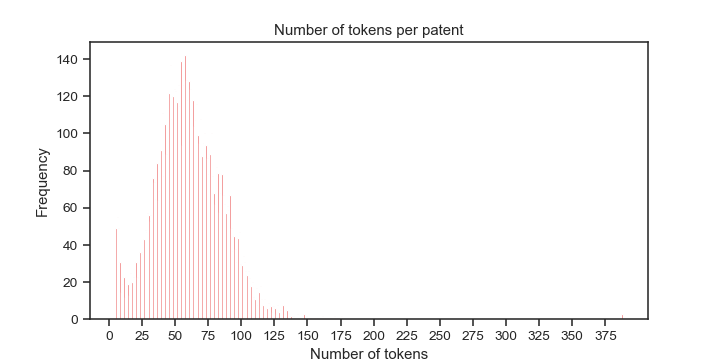

In [70]:
# Count the number of tokens per product
number_token_list = [len(tokens) for tokens in token_list_np]

# Draw a bar plot
plt.figure(figsize=(8,4))

plt.hist(number_token_list, bins=max(number_token_list)-min(number_token_list), color='lightcoral') 
plt.xticks(range(0, max(number_token_list), 25))
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Number of tokens per patent') 

plt.show()

In [71]:
# Show the summary statistics as a DataFrame
print('The summary statistics of the number of tokens per patent:')
pd.DataFrame(pd.Series(number_token_list).describe(percentiles=[0.25, 0.75, 0.9])).transpose()

The summary statistics of the number of tokens per patent:


,count,mean,std,min,25%,50%,75%,90%,max
0,7355.0,60.346567,26.569134,5.0,43.0,59.0,77.0,93.0,388.0


The minimum number of tokens per patent became 5. The patents using the titles as the abstracts would have relatively fewer tokens. This might affect the calculation of the similarities between patents. 

## 4. Modeling

Network analysis and a sentence similarity are combined for the recommendation systems to maximize the accuracy of recommendation. A network allows us to easily extract patents sharing IPC codes with an input patent. Although the extracted patents are guaranteed to share at least one feature (IPC code), the number of the extracted patents could be large (because some patents have many IPC codes). That is why the sentence similarity of the abstracts is used to prioritize them.    

4.1. Sentence similarity  
4.2. Build a network  
4.3. Create recommendation systems

### 4.1. Sentence similarity

The abstracts in the dataset are written in 19 kinds of languages (see 2.6. Language variety). Because I understand English and Japanese and they are the most major languages in the data, I have decided to use the abstracts written in English or Japanese. The Japanese abstracts were translated into English (see 3.1. Translate Japanese to English.) As a result, the sentence similarities are calculated between 7,355 patents (90%.)  
  
Tf-idf vectorizer is chosen to transform the token list into a vector so that the importance of each word is standardized. A unigram, bigram, and trigram are used because compound names are often composed of several words. For example, methyl methacrylate, poly (1,5-dioxepan-2-one), or poly (ethylene -co- acrylic acid). They should be considered in the calculation. To reduce the complexity, the tokens appearing less than three patents are ignored.   

In [72]:
# Vectorization
def dummy_tokened(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=dummy_tokened, lowercase=False, ngram_range=(1, 3), min_df=3)
vecs = vectorizer.fit_transform(token_list_np)

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Show the shape of the matrix
print('Tf-idf matrix: vecs')
print('Matrix shape:', vecs.shape)

Tf-idf matrix: vecs
Matrix shape: (7355, 45438)


Use cosine similarity to calculate the sentence similarities. Cosine similarity is often used to measure the similarities between texts. To evaluate the accuracy, the number of common IPC codes is counted. IPC codes are not exhaustively assigned, but the tendency will be shown.

In [73]:
# Calculate the cosine similarities
cs_array = np.round(cosine_similarity(vecs.toarray(), vecs.toarray()),3)

# Store the similarities in a new DataFrame
df_similarities = pd.DataFrame(cs_array, 
                               index=df_enja_abst_more5['Patent_Id'], 
                               columns=df_enja_abst_more5['Patent_Id'])

print('df_similarities (first 5 rows):')
df_similarities.head()

df_similarities (first 5 rows):


Patent_Id,US293704217,JP293331568,WO2020059793,JP290898185,WO2020066679,WO2020084945,JP290898180,JP293031281,RU291513243,RU282814286,...,CA284258825,CA94508293,CA94882924,CA124239679,CA160355655,CA94262256,CA93908381,CA224370974,CA93894881,CA189885070
Patent_Id,,,,,,,,,,,,,,,,,,,,,
US293704217,1.000,0.002,0.003,0.013,0.006,0.035,0.016,0.002,0.006,0.019,...,0.004,0.034,0.008,0.003,0.002,0.008,0.000,0.027,0.026,0.039
JP293331568,0.002,1.000,0.006,0.021,0.001,0.031,0.017,0.042,0.018,0.034,...,0.006,0.010,0.036,0.015,0.002,0.036,0.018,0.015,0.016,0.045
WO2020059793,0.003,0.006,1.000,0.015,0.006,0.224,0.026,0.001,0.020,0.017,...,0.003,0.009,0.024,0.018,0.002,0.024,0.006,0.005,0.002,0.013
JP290898185,0.013,0.021,0.015,1.000,0.007,0.038,0.020,0.014,0.066,0.030,...,0.005,0.033,0.084,0.022,0.021,0.084,0.018,0.015,0.043,0.011
WO2020066679,0.006,0.001,0.006,0.007,1.000,0.021,0.012,0.002,0.003,0.008,...,0.003,0.006,0.002,0.004,0.005,0.002,0.004,0.001,0.033,0.013


In [74]:
# Evaluate the accuracy
# Get patent IDs having an English or Japanese abstract
enja_patents_list = list(df_enja_abst_more5['Patent_Id'])

# Make a list to store the number of the common IPC codes to each one of enja_patents_list 
num_commonIpc_list = []

# Sort patent IDs by the similarities to each patent, and count the number of common IPC codes
for patent in tqdm(enja_patents_list):
    # IPC codes of a current target patent
    target_ipcs = patent_ipc_dict[patent]
    # Get the patent IDs in the descending order
    similar_patents = df_similarities.loc[patent].sort_values(ascending=False).index
    
    # Make a list to store the number of the common IPC codes
    n_common_ipcs = []
    
    # Extract similar_patents' IPC codes, and count the number of common IPC codes
    for sim_patent in similar_patents:
        # Get the IPC codes of the similar patent
        similar_patent_ipcs = patent_ipc_dict[sim_patent]
        # Count the number of common IPC codes
        n_common_ipc = len(set(target_ipcs) & set(similar_patent_ipcs))
        # Add the number in n_common_ipcs
        n_common_ipcs.append(n_common_ipc)
    
    # Add the list in num_commonIpc_list
    num_commonIpc_list.append(n_common_ipcs)    

# Transform the list to numpy array for later
num_commonIpc_array = np.array(num_commonIpc_list)

# Calculate the means of common IPC codes
mean_num_commonIpc = np.mean(num_commonIpc_array, axis=0)
# Calculate the mean of the means
mean_mean_num_commonIpc = np.mean(mean_num_commonIpc)

100%|██████████████████████████████████████| 7355/7355 [01:40<00:00, 73.05it/s]


<IPython.core.display.Javascript object>


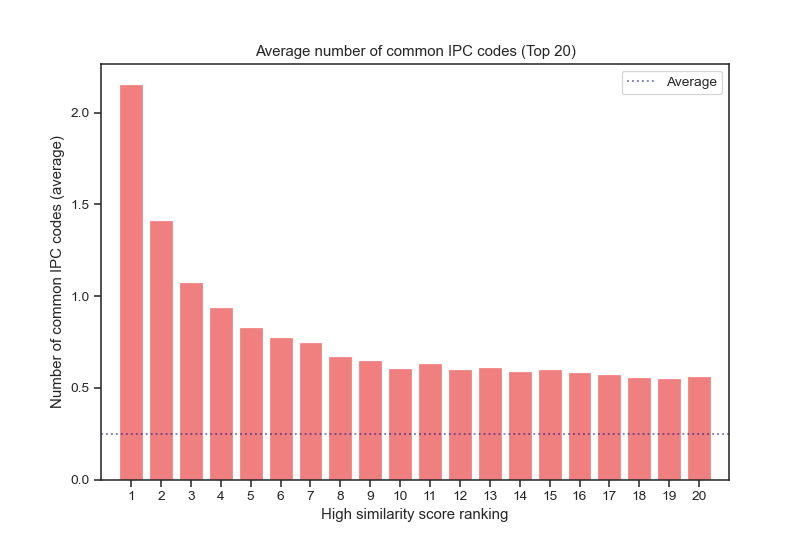

In [75]:
# Create a bar plot
plt.figure(figsize=(9,6))

# Plot from the second to 21st (because the first one is the number of IPC codes of itselt)
plt.bar(range(1, len(mean_num_commonIpc[1:21])+1), mean_num_commonIpc[1:21], color='lightcoral') 
plt.xlabel('High similarity score ranking')
plt.ylabel('Number of common IPC codes (average)')
plt.xlim([0,21])
plt.xticks(np.arange(1, 21, 1))
plt.axhline(xmin=0, xmax=21, y=mean_mean_num_commonIpc, c='navy', alpha=0.5, ls=':', label='Average')

plt.legend()
plt.title('Average number of common IPC codes (Top 20)')

plt.show()

The higher similarity scores, the more common IPC codes. The similarity calculation works well. Use the similarity scores for the recommendation system.

### 4.2. Build a network

Here, the second feature of the recommendation systems, a network, is built. Using a network analysis allows the recommendation systems to easily extract neighbor nodes (in this case, neighbor nodes are patents or IPC codes.) 

4.2.1. Create a graph (network)  
4.2.2. Create a patent projection graph

#### 4.2.1. Create a graph (network)

A network is composed of nodes and edges. There are 2 kinds of nodes: patent nodes and IPC code nodes. A patent node is always connected to IPC code nodes by edges if the patent has the IPC codes. There are 8,182 patents and 4,344 IPC codes in the data. The number of nodes will be 12,526 in total.

In [76]:
# Instantiate a new Graph
G = nx.Graph()

# Add patent nodes
G.add_nodes_from(df['Patent_Id'], bipartite='patent', application=False)

# Add IPC code nodes
for ipc in ipc_freq.keys():
    if ipc[:3] in app_count_dict.keys():
        G.add_node(ipc, bipartite='ipc', application=True)
    else:
        G.add_node(ipc, bipartite='ipc', application=False)
        
# Add edged 
for patent, ipcs in patent_ipc_dict.items():
    for ipc in ipcs:
        if ipc in ipc_freq.keys():
            G.add_edge(patent, ipc)
            
print('Patent-IPC graph: G')

Patent-IPC graph: G


In [77]:
# The number of nodes and edges
print('The number of nodes:', len(G.nodes()))
print('The number of edges:', len(G.edges()))

The number of nodes: 12526
The number of edges: 46012


In [78]:
# Assert statement: the number of nodes of G is equal to the sum of the number of patents and IPC codes
assert len(G.nodes()) == len(df) + len(ipc_freq.keys())

Check how many kinds of applications are in the graph (at a subgroup level). Remember some IPC classes were chosen as applications, app_count_dict.

In [79]:
# Count the number of application nodes
n_app = list(nx.get_node_attributes(G, 'application').values()).count(True)

print('Application kinds:', n_app)

Application kinds: 2153


There are 2,153 kinds of applications in the data. The recommended applications will be chosen among them. 

**< Example >**  
Before making the recommendation systems, explore the network. As an example, I extract the network around 'JP271085664'.

In [80]:
# Extract the neighbors (IPC codes which 'JP271085664' has )
ex_patent = 'JP271085664'
nei_JP271085664_set = set(G.neighbors(ex_patent))

print('The neighbors of "JP271085664" (IPC codes "JP271085664" has):')
nei_JP271085664_set

The neighbors of "JP271085664" (IPC codes "JP271085664" has):


{'A61L 31/00', 'C08K 5/521', 'C08L 101/00', 'C08L 67/00'}

In [81]:
# Make a set to store the neighbors of the neighbors
nei_patents_set = set()

# Extract the neighbors of the neighbors
for ipc in nei_JP271085664_set:
    nei_patents_set = nei_patents_set.union(set(G.neighbors(ipc)))

# The number of the nodes
print('The number of patents sharing the same IPC codes with "JP271085664":', len(nei_patents_set))

The number of patents sharing the same IPC codes with "JP271085664": 2313


The patent, 'JP271085664', has four IPC codes, and the four IPC codes are connected to 2,313 patents in total. Here, I would like to visualize the network. Because it's very big. I pick up one IPC code, 'A61L 31/00', and visualize the network having nodes of 'JP271085664', the four IPC codes, and the neighbor patents of 'A61L 31/00'.

In [82]:
# Extract the neighbor patents of 'A61L 31/00'
nei_A61L3100_set = set(G.neighbors('A61L 31/00'))

# Combine the patent nodes and IPC code nodes
neighbors_set = nei_JP271085664_set.union(nei_A61L3100_set)

# Make a subgraph of the neighbors
G_JP271085664 = G.subgraph(neighbors_set)
print('The subgraph around "JP271085664": G_JP271085664')

# Show the number of the nodes
print('The number of the nodes of G_JP271085664:', len(list(G_JP271085664.nodes())))

The subgraph around "JP271085664": G_JP271085664
The number of the nodes of G_JP271085664: 101


<IPython.core.display.Javascript object>


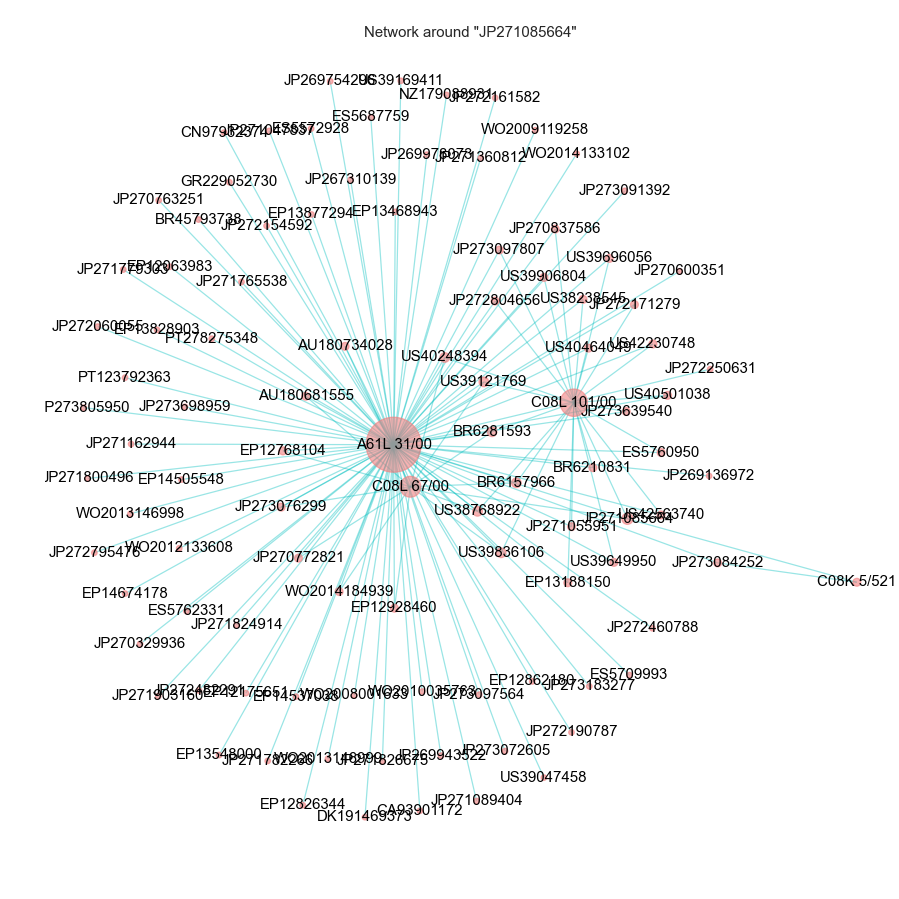

In [83]:
# Make a list to store the node sizes
node_size_list = []

# Count the number of edges of each nodes, and multiple 20 for the node size
for node in list(G_JP271085664.nodes()):
    n_edges = len(list(G_JP271085664.neighbors(node)))
    # To easily see the differences
    node_size_list.append(n_edges*20)

# Plot the network of G_JP271085664
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G_JP271085664, k=0.1)
nx.draw_networkx_nodes(G_JP271085664, pos, node_color="lightcoral",alpha=0.6, node_size=node_size_list)
nx.draw_networkx_labels(G_JP271085664, pos, fontsize=1)
nx.draw_networkx_edges(G_JP271085664, pos, alpha=0.4, edge_color='c')

plt.axis('off')
plt.subplots_adjust(left=0.05, right=0.995, bottom=0.05, top=0.95)
plt.title('Network around "JP271085664"')
plt.show()

'JP271085664' is connected to the four IPC codes, 'A61L 31/00', 'C08K 5/521', 'C08L 101/00', and 'C08L 67/00'. Then, 'A61L 31/00' has a connection with 97 patents. According to the network plot, 'C08L 101/00' and 'C08L 67/00' have some connections with the patents 'A61L 31/00' is connected to.  
  
This network is a part of the original graph. The whole graph is more highly connected.

#### 4.2.2. Create a patent projection graph

The graph G has two kinds of nodes (patent nodes and IPC code nodes.) Here, I make a new graph having only patent nodes. The new graph is made by projecting the relationships between patent nodes and IPC code nodes. For example, if a patent (P1) has some IPC codes (IPC1 and IPC2) and another patent (P2) has some IPC codes (IPC1, IPC3), it is said that P1 and P2 are indirectly connected through IPC1. In this case, the new graph will have an edge between P1 and P2.  
  
Create a patent projection graph.

In [84]:
# Get the patent nodes
patent_nodes = [node for node, metadata in G.nodes(data=True) if metadata['bipartite'] == 'patent']

# Create the patent node projection 
G_patents = nx.bipartite.projected_graph(G, nodes=patent_nodes)

print('Patent projection graph: G_patents')

# The number of nodes and edges
print('The number of nodes:', len(G_patents.nodes()))
print('The number of edges:', len(G_patents.edges()))

Patent projection graph: G_patents
The number of nodes: 8182
The number of edges: 7035567


Degree centrality is a rate of the number of edges to the potential number of edges. If it is 1, the node is connected to all the other nodes, and if it is 0.5, the node is connected to the half of the other nodes.  
  
Visualize the degree centrality distribution of the patent projection. 

<IPython.core.display.Javascript object>


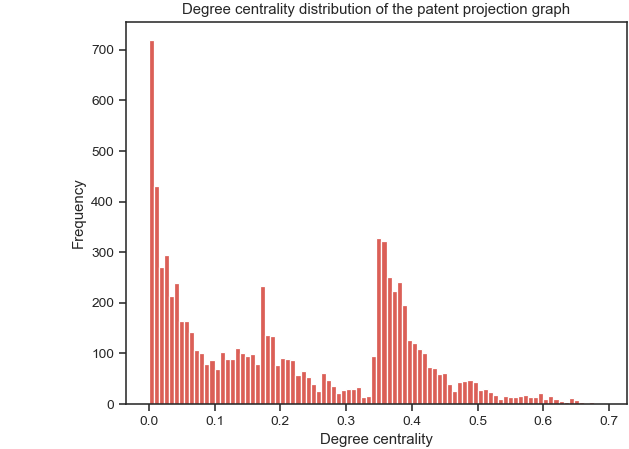

In [85]:
# Calculate the degree centrality 
degree_centrality_patent = nx.degree_centrality(G_patents)

# Plot the histogram of degree centrality values
plt.figure(figsize=(7,5))
plt.hist(list(degree_centrality_patent.values()), bins=int(np.sqrt(len(G_patents.nodes()))))

plt.xlabel('Degree centrality')
plt.ylabel('Frequency')

plt.title('Degree centrality distribution of the patent projection graph') 

plt.subplots_adjust(left=0.2, right=0.995, bottom=0.1, top=0.95)
plt.show() 

There are three peaks around 0, 0.18, and 0.36. Because the graph has 8,182 nodes, 0.18 means more than 1470 connections and it is a lot. That is why the sentence similarity is used to prioritize them. On the other hand, if degree centrality is very close to 0, the patent has only a few edges (connections with the other patents.) Then, the neighbor patents might or might not be connected to the other patents. If not, the network is closed. In the graph, all of the patent nodes might not be connected. In this case, the graph is composed of some subgraphs. Check the number of subgraphs and the number of patents in each subgraph.

In [86]:
# Extract the patents in each subgraph
patents_inSubgraph_list = list(nx.connected_components(G_patents))

# Number of subgraphs
print('The number of subgraphs in G_patents:', len(patents_inSubgraph_list))

The number of subgraphs in G_patents: 46


<IPython.core.display.Javascript object>


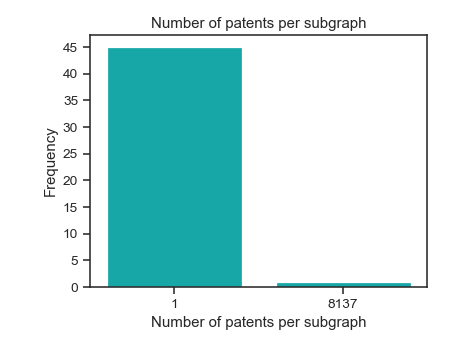

In [87]:
# Count the number of patents in each subgraph
numPatents_inSubgraph_list = list(map(lambda patents: len(patents), patents_inSubgraph_list))

# Draw a count plot
plt.figure(figsize=(5,4))

sns.countplot(x=numPatents_inSubgraph_list, color='c')
plt.ylabel('Frequency')
plt.xlabel('Number of patents per subgraph')
plt.title('Number of patents per subgraph')
plt.yticks(range(0, 50, 5))

plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.90)
plt.show()

There are one huge subgraph and 45 small subgraphs. The small subgraphs have only one component, that is, each subgraph is composed of one patent. They don't have any neighbor patents, and it's impossible to extract the applications from the neighbors. On the other hand, all patents are connected by 'C08L 101/16.' Then, in the case, recommended applications will be extracted from patents having the most similar abstract. 

### 4.3. Create recommendation systems

Finally, create recommendation systems. I make two versions of the recommendation systems. The first one accepts one patent from a user and recommends up to 10 applications. The second one accepts two IPC codes from a user and recommends up to 10 applications.

4.3.1. Create the recommendation system 1 accepting one patent as input  
4.3.2. Create the recommendation system 2 accepting two IPC codes as input  
4.3.3. Unit test

#### 4.3.1. Create the recommendation system 1 accepting one patent as input

When a user already published a patent in the biodegradable polymer field and wants to know other potential applications for their polymer, this recommendation system would be used. The patent a user inputted should be in the data.  
  
For example, suppose that Company_A published Patent_1 about a biodegradable suture using polyglycolide, and they want to know that their polyglycolide could be used for the other applications. They would input Patent_1 in the system and would get 10 potential applications. Also, the patent could be a competitor's patent.  
  
Two cases should be recognized to create the system successfully. The first case is that the input patent does not have any neighbor patent. Remember that 45 patents form individual subgraphs. In this case, the network would not be able to be used to extract similar patents, but the sentence similarity would be. Another case is that the input patent does not have an English or Japanese abstract (10%). In this case, the extracted neighbor patents by the network would not be able to be prioritized. I have decided to show a warning and use the unsorted patent list for the following steps. These two cases could be combined. To deal with them:  
  
|Neighbor patents|English or Japanese abstract|Sign|Handling|  
|:-------------:|:--------------------------:|:--:|:------:|  
|Yes|Yes|-|Extract neighbor patents using the network and prioritize them by the sentence similarity|
|No|No|Error 2|Exit the system|  
|No|Yes|Warning 1|Extract similar patents in similar order by the sentence similarity|  
|Yes|No|Warning 2|Extract neighbor patents using the network and use the neighbor patents without sorting|

The workflow of the recommendation system accepting one patent as input:  <img src="system_1.png" width="700px">

When prioritizing the neighbor patents, some patents may not have an English or Japanese abstract. In this case, the average score of the input patent is used as the similarity score. When extracting recommended applications, application IPC codes shared with the input patent at a maingroup level are removed so that the recommended applications are not too close to the applications of the input patent.  
  
First, define the function running the recommendation system 1 (`recommend_app_from_patent`.) `recommend_app_from_patent` accepts one patent and returns a message list and a recommended application dictionary. The message list stores errors and/or warnings appearing in the system. The recommended application dictionary has recommended application IPC codes as the keys and the reference patents as the values.  

`recommend_app_from_patent`: a function running the recommendation system 1

In [88]:
# Recommend applications from one patent (system1)
def recommend_app_from_patent(patent_id):
    '''
    Return a message list and a recommended application dictionary when one patent ID (patent_id) is given by a user. 
    The input patent should be included in the original data.
    ''' 
    # To keep error or/and warning messages (This will be returned)
    messages = []
    # To keep application IPC codes and reference patents (This will be returned)
    appIpc_refPatents = {}
    
    # Check if the patent ID is in the system
    if patent_id not in list(G_patents.nodes()):
        # Get error1 and exit the system
        messages.append('Error1')
        return messages, appIpc_refPatents
    
    else:
        # Get the neighbor patents
        neighbor_patents = set(G_patents.neighbors(patent_id))
        # To count patents checked
        checked_patents = set([patent_id])
        # To count IPC codes checked
        checked_ipcs = set(G.neighbors(patent_id))
        # Keep the IPC codes (maingroup level) of the input patent  
        original_ipc_maingroups = set(map(lambda ipc: re.match('[A-Z][0-9]+[A-Z][ ][0-9]+', ipc).group(), checked_ipcs))    
        # To check if the warnings have been raised
        raised_warning1 = False
        raised_warning2 = False
        raised_warning3 = False
        
        # Continue the loop until getting 10 recommended applications
        while len(appIpc_refPatents) < 10:
            # To temporally keep patent IDs and the similarities
            id_simi = {}
            
            # Sort all patents by the sentence similarities when there is no neighbor patent
            if len(neighbor_patents) == 0:
                if patent_id in df_similarities.columns:
                    # Get Warning only once
                    if raised_warning1 == False:
                        messages.append('Warning1')
                        raised_warning1 = True
                    
                    patents_simi_order = df_similarities.loc[patent_id].sort_values(ascending=False).index

                # Get error2 and exit the system when patent_id is not in df_similarities
                else: 
                    messages.append('Error2')
                    return messages, appIpc_refPatents
            
            else:
                # Sort the neighbor patents by the sentence similarities when the input patent has an English or Japanese patent
                if patent_id in df_similarities.columns:
                    # Get the similarities of the neighbor patents
                    for patent1 in neighbor_patents:
                        if patent1 in df_similarities.columns:
                            id_simi[patent1] = df_similarities.loc[patent_id, patent1]
                        # Get the mean as the similarity when patent1 doesn't have the similarity
                        else:
                            id_simi[patent1] = df_similarities.loc[patent_id].mean()
                    
                    # Sort the dictionary by the similarities
                    id_simi_sorted = sorted(id_simi.items(), key=lambda x: x[1], reverse=True)
                    # Get the patent IDs
                    patents_simi_order = list(map(lambda tup: tup[0], id_simi_sorted))
                    
                else:
                    # Get Warning2 only once
                    if raised_warning2 == False:
                        messages.append('Warning2')
                        raised_warning2 = True
                    # Use the neighbor patents without sorting
                    patents_simi_order = list(neighbor_patents)
            
            # Get application IPC codes of the neighbor patents
            for patent2 in patents_simi_order:
                checked_patents.add(patent2)
                nei_ipc = set(G.neighbors(patent2)) - checked_ipcs
                
                # Search the IPC codes
                for ipc in nei_ipc:
                    checked_ipcs.add(ipc)
                    # Check if the IPC code is for an application
                    if ipc[:3] in app_count_dict.keys():
                        # Get the maingroup
                        ipc_maingroup = re.match('[A-Z][0-9]+[A-Z][ ][0-9]+', ipc).group()
                        
                        # Check if the maingroup doesn't match the maingroups of the input patent 
                        if ipc_maingroup not in original_ipc_maingroups:
                            # Get the IPC code
                            appIpc_refPatents[ipc] = patent2
                            # Stop the search if we already have 10 recommended applications
                            if len(appIpc_refPatents) == 10:
                                # Return the messages and appIpc_refPatents 
                                return messages, appIpc_refPatents
                    
            # Get the neighbor patents of the neighbor patents when the current number of applications are less than 10
            if len(appIpc_refPatents) < 10:
                # Show Warning3 only once
                if raised_warning3 == False:
                    # Warning3: keep the current number of applications in messages
                    messages.append(len(appIpc_refPatents))
                    raised_warning3 = True
                
                # Because neighbor_patents will be modified for next loop
                neighbor_patents_iter = list(neighbor_patents)
                neighbor_patents = set()
                
                # Get the neighbor patents of the neighbor patents
                for patent3 in neighbor_patents_iter:
                    neighbor_patents = neighbor_patents.union(set(G_patents.neighbors(patent3)))
                    
                neighbor_patents = neighbor_patents - checked_patents

Next, define a function that makes two DataFrames (`make_dataframes`.) `make_dataframes` accepts a recommended application dictionary provided by `recommend_app_from_patent`. One of the DataFrame shows application IPC codes and the reference patents. Another shows the reference patent information (patent IDs, application dates, and titles.) This function will also be used for system 2.

`make_dataframes`: a function making two DataFrames about the recommended applications and the reference patents

In [89]:
def make_dataframes(appIpc_refPatents):
    '''
    Return two DataFrames when the dictionary (appIpc_refPatents) is given.  
    1. df_applications: 10 applications and the reference patents
    2. df_references: the Patent_Id, Application_Date, and Title of the reference patents
    ''' 
    # Make df_applications from appIpc_refPatents
    df_applications = pd.DataFrame({'Application IPC Code': list(appIpc_refPatents.keys()),
                                    'Reference Patent': list(appIpc_refPatents.values())})  
    # Make a new DataFrame of the reference patents
    df_references = pd.DataFrame(columns=['Patent_Id', 'Application_Date', 'Title'])
    # To keep the reference patents as a set
    ref_patents = set()
    
    # Get the reference patents as a set
    for v in appIpc_refPatents.values():
        if type(v) == str:
            ref_patents.add(v)
        else:
            ref_patents = ref_patents.union(v)
    
    # Extract the patent information
    for ref in ref_patents:
        df_references = df_references.append(df[df['Patent_Id'] == ref][['Patent_Id', 'Application_Date', 'Title']])
    
    # Return the two DataFrame
    return df_applications, df_references

Lastly, define a function that prints the result with a format (`show_result`.) `show_result` accepts five arguments (messages, df_applications, df_references, user_input1, and user_input2.) user_input1 is an input patent or IPC code, and user_input2 is another IPC code. When using system 1, the input is only one patent. That is why user_inut2 has '' as a default value. Messages is a message list from `recommend_app_from_patent`, and is used to show error and/or warning messages. df_applications and df_references are DataFrames provided by `make_dataframes`. This function will also be used for system 2.  

`show_result`: a function that prints the result 

In [90]:
def show_result(messages, df_applications, df_references, user_input1, user_input2=''):
    '''
    Print the result of the recommendation systems 
    ''' 
    # Print the user input
    print('===============================================================================================================')
    print('User input:', user_input1, ',', user_input2)
    print('')
    
    # Print the messages
    for message in messages:
        # System1
        if message == 'Error1':
            print('** Error **')
            print(user_input1, 'is not acceptable.')
            print('Check the format (e.g., "JP272810309"), use the other patent, or use IPC codes instead. [Error1]')
   
        elif message == 'Error2':
            print('** Error **')
            print('The patent ID is not acceptable.')
            print('Use the other patent, or use IPC codes instead. [Error2]')
    
        elif message == 'Warning1':
            print('** Rough estimate **')
            print('No neighbor patent [Warning1]')
    
        elif message == 'Warning2':
            print('** Rough estimate **')
            print(user_input1, "doesn't have an English or Japanese abstract. [Warning2]")
        
        # System 1 and 2
        elif type(message) == int:
            print('** Rough estimate **')
            print('The second-tiers after', message, '[warning3]')
        
        # System2
        elif message == 'Error3':
            print('** Error **')
            print(user_input1, 'is not acceptable.')
            print('Check the format (e.g., "C08L 101/16") or use the other IPC codes instead. [Error3]')
    
        elif message == 'Error4':
            print('** Error **')
            print(user_input2, 'is not acceptable.')
            print('Check the format (e.g., "C08L 101/16") or use the other IPC codes instead. [Error4]')
        
        elif message == 'Error5':
            print('** Error **')
            print('No connection between the two IPC codes. Try a different combination. [Error5]')   
        print('')
    
    # Print the recommended applications and the reference patents
    if len(df_applications) > 0:
        # Print recommended application codes and the reference patents
        print('Recommended application codes and the reference patents:')
        print('-------------------------------------------------------------------------------------------------------------')
        print(df_applications)
        print('-------------------------------------------------------------------------------------------------------------')
        print('')
                            
        # Print the titles of the reference patents
        print('The reference patents:')
        print('-------------------------------------------------------------------------------------------------------------')
        print(df_references)
        print('-------------------------------------------------------------------------------------------------------------')
        
    print('===============================================================================================================')

Try system 1. Check the time taken and the example of the output to confirm this system works appropriately. Execute the system several times.

In [91]:
%%time

# Example 
patent = random.choice(df['Patent_Id'])
messages, appIpc_refPatents_dict= recommend_app_from_patent(patent)
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=patent)

User input: JP270180631 , 

Recommended application codes and the reference patents:
-------------------------------------------------------------------------------------------------------------
  Application IPC Code Reference Patent
0            A01G 9/14      JP270290052
1           C09K 19/20       US39738660
2           C09K 19/38       US39738660
3            H05K 1/03       US39738660
4            A01G 7/00      JP270080069
5           A01M 21/00      JP270080069
6           D21H 21/36       EP13864939
7           A01M 29/00       EP13864939
8           C09K 17/32       EP13864939
9           D21H 21/14       EP13864939
-------------------------------------------------------------------------------------------------------------

The reference patents:
-------------------------------------------------------------------------------------------------------------
        Patent_Id Application_Date  \
4798  JP270080069       14.04.2003   
5787   EP13864939       31.03.2000   
5791   

The system worked. It returned 10 applications and an appropriate message. It took less than 100 ms. It would be fast enough. This system is tested at 4.3.3. Unit test more precisely, especially special cases (a non-existent patent, a no-neighbor patent, and a non-English or Japanese abstract) will be checked whether they cause an appropriate error or warnings. 

#### 4.3.2. Create the recommendation system 2 accepting two IPC codes as input

When a user does not have any target patent and wants to search for some applications from IPC codes, this second recommendation system would be used. The IPC codes inputted by a user should be in the data.  
  
For example, suppose that Company_B is developing a biodegradable suture using polyglycolide (they do not have the patent yet), and wants to know other potential applications for their polymer. They would search the IPC codes of polyglycolide (C08G 63/06) and a biodegradable suture (A61L 17/06, A61L 17/08, or A61L 17/12 (IPC is a hierarchic structure. I recommend to try several IPC codes that are related to what you want to search).) Then, they input two IPC codes (e.g., C08G 63/06 and A61L 17/08) into the system and would get up to 10 potential applications.  
  
This second recommendation system uses the network mainly. A user inputs two IPC codes, and the system finds the neighbor patens of each IPC code. Then, the intersection patents are searched, and the IPC codes of the intersection patents are extracted and counted. The most frequent 10 applications are selected as the recommended applications. Because IPC codes are inputted instead of a patent, the sentence similarity is not usable. That is why the majority voting is used to prioritize the extracted IPC codes. If 10 applications are not provided from the intersection patents, the neighbor patents of the intersection patents are found and the 10 neighbor patents that are the most similar to the intersection patents in terms of the sentence similarity are used as the new intersection patents. If there is no new intersection patent, the system cannot continue the following steps. In this case, the current application list is printed.

The workflow of the recommendation system accepting two IPC codes as input:  <img src="system_2.png" width="700px">

In [92]:
# Recommend applications from two IPC codes (system 2)
def recommend_app_from_2ipcs(ipc1, ipc2):
    '''
    Return a message list and a recommended application dictionary when two IPC codes (ipc1 and ipc2) are given. 
    The IPC codes should be included in the original data.
    '''    
    # To keep error or/and warning messages (This will be returned)
    messages = []
    # To keep application IPC codes and reference patents (This will be returned)
    appIpc_refPatents = {}
    
    # Return the error message and empty appIpc_refPatents if either of the IPC codes is not in the system
    if ipc1 not in list(G.nodes()):
        messages.append('Error3')
        return messages, appIpc_refPatents
    elif ipc2 not in list(G.nodes()):
        messages.append('Error4')
        return messages, appIpc_refPatents
        
    else:
        # To count IPC codes checked
        checked_ipcs = set([ipc1, ipc2])
        # Keep the maingroups of the input IPC codes  
        original_ipc_maingroups = set(map(lambda ipc: re.match('[A-Z][0-9]+[A-Z][ ][0-9]+', ipc).group(), checked_ipcs))
        
        # Get the neighbor patents for each IPC code
        frontier_patents_1 = set(G.neighbors(ipc1))
        frontier_patents_2 = set(G.neighbors(ipc2))
        # Keep frontier patents
        frontiers = frontier_patents_1.union(frontier_patents_2)
        
        # Keep patents close to each IPC code
        neighbor_patents_1 = set(frontier_patents_1)
        neighbor_patents_2 = set(frontier_patents_2)
        # Get the intersection
        intersection_12 = neighbor_patents_1 & neighbor_patents_2
        
        # Get the closest common patents
        while len(frontiers) != 0:
            # Go to the next step if already having common patents
            if len(intersection_12) != 0:
                break
                
            # Get the neighbor patents of the neighbor patents when intersection_12 is empty
            else:
                # To keep frontier patents temporary
                frontier_patents_1_temp = set()
                frontier_patents_2_temp = set()
                
                # Get the frontier patents
                for patent1 in frontier_patents_1:
                    frontier_patents_1_temp = frontier_patents_1_temp.union(set(G_patents.neighbors(patent1)))
                for patent2 in frontier_patents_2:
                    frontier_patents_2_temp = frontier_patents_2_temp.union(set(G_patents.neighbors(patent2)))
                
                # Only get new patents as frontier_patents
                frontier_patents_1 = frontier_patents_1_temp - neighbor_patents_1
                frontier_patents_2 = frontier_patents_2_temp - neighbor_patents_2
                
                # Keep the new patents in each IPC code group
                neighbor_patents_1 = neighbor_patents_1.union(frontier_patents_1)
                neighbor_patents_2 = neighbor_patents_2.union(frontier_patents_2)
                
                # Get the intersection
                intersection_12 = neighbor_patents_1 & neighbor_patents_2
                
                # Combine frontier_patens_1 and _2
                frontiers = frontier_patents_1.union(frontier_patents_2)
        
        # Return the error message and appIpc_refPatents if we couldn't find any common patent, and end the searching
        if len(frontiers) == 0:
            messages.append('Error5')
            return messages, appIpc_refPatents
                
        else:
            # To count patents checked
            checked_patents = set()
            # To check if the warning has been shown
            warning_appear = False
        
            # Continue the loop until getting 10 recommended applications
            while len(appIpc_refPatents) < 10:
                nei_ipc = []
                
                # Get application IPC codes of the neighbor patents
                for patent3 in intersection_12: 
                    checked_patents.add(patent3)
                    nei_ipc.extend(set(G.neighbors(patent3)) - checked_ipcs)
                    
                # Count each IPC code
                nei_ipc_count = Counter(nei_ipc)
                # Sort the dictionary by the frequency
                nei_ipc_count_sorted = sorted(nei_ipc_count.items(), key=lambda x: x[1], reverse=True)
                # Get the IPC codes
                nei_ipc_sorted = list(map(lambda tup: tup[0], nei_ipc_count_sorted))
                
                # Check the IPC codes of the intersection patents to find applications
                for ipc in nei_ipc_sorted:
                    checked_ipcs.add(ipc)
                    
                    # Check if the IPC code is for an application 
                    if ipc[:3] in app_count_dict.keys():
                        # Get the maingroup
                        ipc_maingroup = re.match('[A-Z][0-9]+[A-Z][ ][0-9]+', ipc).group()
                        
                        # Check if the maingroup doesn't match the maingroups of the input IPC codes
                        if ipc_maingroup not in original_ipc_maingroups:
                            # Keep the IPC code as an application and the reference patents
                            appIpc_refPatents[ipc] = set(G.neighbors(ipc)) & intersection_12
                        
                            # Stop the search if we already have 10 recommended applications
                            if len(appIpc_refPatents) == 10:
                                # Return the messages and appIpc_refPatents and exit the system
                                return messages, appIpc_refPatents
                
                # Get the neighbor patents of the intersection patents if the current number of applications is less than 10
                if len(appIpc_refPatents) < 10:
                    # Because intersection_12 will be modified for next loop
                    intersection_12_temp = list(intersection_12)
                    intersection_12 = set()
                    
                    # Get the neighbor patents of the intersection patents 
                    for patent4 in intersection_12_temp:
                        intersection_12 = intersection_12.union(set(G_patents.neighbors(patent4)))
                        
                    intersection_12 = intersection_12 - checked_patents
                    
                    # Prepare for the second cycle
                    if len(intersection_12) != 0:
                        # Show Warning3 only once
                        if warning_appear == False:
                            # Warning3: keep the current number of applications in messages
                            messages.append(len(appIpc_refPatents))
                            warning_appear = True
                        
                        # Make a dictionary having patent IDs as keys and 0s as values (to keep the sentence similarity scores)
                        id_simi = dict([(patent5,0) for patent5 in intersection_12])
                        
                        # Get the sentence similarity scores of the new intersection patents
                        for patent6 in intersection_12_temp:
                            if patent6 in df_similarities.columns:
                                # Get the similarities of the neighbor patents
                                for patent7 in intersection_12:
                                    if patent7 in df_similarities.columns:
                                        if id_simi[patent7] < df_similarities.loc[patent6, patent7]:
                                            id_simi[patent7] = df_similarities.loc[patent6, patent7]
                                    # Get the mean as the similarity when patent7 doesn't have the similarity
                                    else:
                                        id_simi[patent7] = df_similarities.loc[patent6].mean()
                    
                        # Sort the dictionary by the similarities
                        id_simi_sorted = sorted(id_simi.items(), key=lambda x: x[1], reverse=True)
                        # Get the top 10 similar patents and assign them as intersection_12
                        intersection_12 = set(list(map(lambda tup: tup[0], id_simi_sorted))[:10])
                            
                    else:
                        # Return the messages and appIpc_refPatents, and exit the system
                        return messages, appIpc_refPatents

Try system 2. Check the time taken and the example of the output to confirm this system works appropriately. Execute the system several times.

In [99]:
%%time

# Example 
ipcs = random.sample(list(ipc_freq.keys()), 2)
messages, appIpc_refPatents_dict = recommend_app_from_2ipcs(ipcs[0], ipcs[1])
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=ipcs[0], user_input2=ipcs[1])

User input: A01H 5/00 , H01L 23/14

** Error **
No connection between the two IPC codes. Try a different combination. [Error5]

Wall time: 2.72 s


System 2 returned 10 applications and an appropriate message. It took only 2 seconds even if it took longer. It would be acceptable.

In the next section, several cases are tested to confirm the system. The examples would be a non-existent IPC code, no connection between two IPC codes, and no intersection in the first cycle. 

#### 4.3.3. Unit test

Here, the functions of system 1 and 2 are tested (`recommend_app_from_patent`, `recommend_app_from_2ipcs`) to confirm if they raise appropriate messages in specific cases.   
  
Seven tests are written for `recommend_app_from_patent`. One of them is a fine case that does not raise any errors or warnings. Two of them are the cases of Error1 and Error2. Three of them are the cases of Warning1, Warning2, and Warning3. One of them is a combination of Warning2 and Warning3. Five tests are prepared for `recommend_app_from_2ipcs`. They are also a fine case, Error3, Error4, Error5, and Warning3. These seven and five cases are all of the potential cases of `recommend_app_from_patent` and `recommend_app_from_2ipcs`, respectively. If they raise appropriate errors and/or warnings, it is said the functions work as I intended.

Also, one test is written for `make_dataframes` to check the function makes two DataFrames from a dictionary.  

In [100]:
import unittest

class TestNotebook(unittest.TestCase):
    
    # System1 (recommend_app_from_patent)
    # Test a fine case: no error, no warning
    def test_recommend_app_from_patent_noerror(self):
        # This patent has neighbor patents and an English title used as the abstract
        patent = 'GR229064034'
        messages, _ = recommend_app_from_patent(patent)
        expected_messages = []
        self.assertEqual(expected_messages, messages)
    
    # Test Error1: no existent patent
    def test_recommend_app_from_patent_error1(self):
        # This patent does not exist in the graph. This should cause Error1.
        patent = 'JP273436361'
        messages, _ = recommend_app_from_patent(patent)
        expected_messages = ['Error1']
        self.assertEqual(expected_messages, messages)
        
    # Test Error2: no neighbor patent nor an English or Japanese abstract
    def test_recommend_app_from_patent_error2(self):
        # This patent does not have any neighbor patent nor an English or Japanese abstract.This should cause Error2.
        patent = 'ID202886819'
        messages, _ = recommend_app_from_patent(patent)
        expected_messages = ['Error2']
        self.assertEqual(expected_messages, messages)
    
    # Test Warning1: no neighbor patent, has an English or Japanese abstract
    def test_recommend_app_from_patent_warning1(self):
        # This patent does not have any neighbor patent, but has an English or Japanese abstract.This should cause Warning1.
        patent = 'JP273284580'
        messages, _ = recommend_app_from_patent(patent)
        expected_messages = ['Warning1']
        self.assertEqual(expected_messages, messages)
    
    # Test Warning2: has neighbor patents, no English or Japanese abstract
    def test_recommend_app_from_patent_warning2(self):
        # This patent has neighbor patents, but doesn't has an English or Japanese abstract.This should cause Warning2.
        patent = 'BR6093184'
        messages, _ = recommend_app_from_patent(patent)
        expected_messages = ['Warning2']
        self.assertEqual(expected_messages, messages)   

    # Test Warning3: less than 10 applications in the first cycle
    def test_recommend_app_from_patent_warning3(self):
        # This patent has 22 neighbor patents and an English or Japanese abstract.
        # The 6 neighbor patents have 1 application IPC code in total. This should cause Warning3.
        patent = 'JP269435391'
        messages, _ = recommend_app_from_patent(patent)
        # Warning3 shows the number of application IPC codes collected in the first cycle
        expected_messages = [1]
        self.assertEqual(expected_messages, messages)        
        
    # Test Warning2and3: has neighbor patents, no English or Japanese abstract, less than 10 applications in the first cycle
    def test_recommend_app_from_patent_warning2and3(self):
        # This patent has 6 neighbor patents, but doesn't has an English or Japanese abstract.This should cause Warning2.
        # The 6 neighbor patents have only 4 application IPC codes in total. This should cause Warning3.
        patent = 'AU194053523'
        messages, _ = recommend_app_from_patent(patent)
        # Warning
        expected_messages = ['Warning2', 4]
        self.assertEqual(expected_messages, messages)
    
    
    # System2 (recommend_app_from_2ipcs)
    # Test a fine case: no error, no warning
    def test_recommend_app_from_2ipcs_noerror(self):
        # These IPC codes have intersection patents, and 10 applications can be extracted from them
        ipc1 = 'A23L 3/3472'
        ipc2 = 'C10G 1/10'
        messages, _ = recommend_app_from_2ipcs(ipc1, ipc2)
        expected_messages = []
        self.assertEqual(expected_messages, messages)
    
    # Test Error3: no existent patent (ipc1)
    def test_recommend_app_from_2ipcs_error3(self):
        # Ipc1 doesn't exist in the graph. This should cause Error3.
        ipc1 = 'C08H 10/20'
        ipc2 = 'A45D 40/20'
        messages, _ = recommend_app_from_2ipcs(ipc1, ipc2)
        expected_messages = ['Error3']
        self.assertEqual(expected_messages, messages)
        
    # Test Error4: no existent patent (ipc2)
    def test_recommend_app_from_2ipcs_error4(self):
        # Ipc2 doesn't exist in the graph. This should cause Error4.
        ipc1 = 'A45D 40/20'
        ipc2 = 'C08H 10/20'
        messages, _ = recommend_app_from_2ipcs(ipc1, ipc2)
        expected_messages = ['Error4']
        self.assertEqual(expected_messages, messages)
    
    # Test Error5: no neighbor patent
    def test_recommend_app_from_2ipcs_error5(self):
        # Neither IPC codes have any neighbor patent. This should cause Error5.
        ipc1 = 'B32B 15/06'
        ipc2 = 'A61K 31/727'
        messages, _ = recommend_app_from_2ipcs(ipc1, ipc2)
        expected_messages = ['Error5']
        self.assertEqual(expected_messages, messages)

    # Test Warning3: less than 10 applications in the first cycle
    def test_recommend_app_from_2ipcs_warning3(self):
        # The intersection patents have 0 applications, and go to the second cycle
        ipc1 = 'B65D 77/30'
        ipc2 = 'A62C 13/66'
        messages, _ = recommend_app_from_2ipcs(ipc1, ipc2)
        expected_messages = [0]
        self.assertEqual(expected_messages, messages)  
    
    
    # make_dataframes
    def test_make_dataframes(self):
        dict_temp = {'A24D 3/10': 'US38770921', 'A24D 3/08': 'EP12864252'}
        actual_df1, actual_df2 = make_dataframes(dict_temp)
        expected_df1 = pd.DataFrame({'Application IPC Code': ['A24D 3/10', 'A24D 3/08'],
                                     'Reference Patent': ['US38770921', 'EP12864252']})
        expected_df2 = pd.DataFrame({'Patent_Id': ['EP12864252', 'US38770921'],
                                     'Application_Date': ['17.10.1996', '20.10.1995'],
                                     'Title': ['Tobacco filter materials and tobacco filter as produced by using the same',
                                               'Tobacco smoke filter materials, fibrous cellulose esters, and production processes']},
                                     index=[6821, 7023])
    
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.............
----------------------------------------------------------------------
Ran 13 tests in 5.547s

OK


These tests didn't cause any errors. It was confirmed that the two systems worked to raise the appropriate errors or warnings as intented. Unit test helps us make sure the functions and will also be useful when the codes are adjusted in the future.

## 5. Recommend Applications (using the model)

In this section, the interfaces of the recommendation systems are created and the examples are presented.  
  
5.1. Use the recommendation system 1  
5.2. Use the recommendation system 2  

### 5.1. Use the recommendation system 1

When executing the following cell, a text input window shows up and accepts input from a user. A user inputs one patent ID, and the system will return the applications.

In [ ]:
# Accept input from a user
user_input = input('Input a patent ID (e.g., JP273590701):')

# Run the recommendation system 1
messages, appIpc_refPatents_dict = recommend_app_from_patent(user_input)
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=user_input)

**< Example 1 >**  
Explore the system about one patent as an example. Here, I picked up 'JP274783873'. Check the patent.

In [102]:
# Show 'JP274783873'
df[df['Patent_Id'] == 'JP274783873']

,Patent_Id,Application_Number,Application_Date,Country,Title,Abstract,IPC,Applicants,Inventors
100,JP274783873,2018097974,22.05.2018,JP,POLYMER COMPOSITION CONTAINING PLLA AND PDLA,"<p>PROBLEM TO BE SOLVED: To provide a polymer having high heat resistant shape stability, biodegradability, and based on an organism-derived raw material and a molded article obtained from the polymer.</p><p>SOLUTION: There is provided a polymer composition containing following components, a. 15 to 70 wt.% of PLLA, b. 0.1 to 15 wt.% of PDLA, c. 5 to 40 wt.% of polyester and d. 5 to 40 wt.% of an organic or inorganic filler, based on total weight of the polymer composition. Such kind of polymer composition can be biodegradated, mainly can contain bio-based carbon and can have high heat resistance. Further such kind of polymer composition can be used in a special method for manufacturing a molded article, a film or a fiber, and the molded article, the film or the fiber can be used as a container for a coffee service system because they are high in heat resistant shape stability.</p><p>SELECTED DRAWING: Figure 1</p><p>COPYRIGHT: (C)2018,JPO&INPIT</p>",C08L 67/04; C08K 3/013; C08L 67/02; C08J 5/00; C08J 5/18; C08L 101/16; D01F 6/62,BIO-TEC BIOLOGISCHE NATURVERPACKUNGEN GMBH & CO KG; バイオ－テック ビオローギッシュ ナチューフェアパックンゲン ゲーエムベーハー ウント コンパニ カーゲー,SCHMIDT HARALD; ハラルド シュミット; CHRISTOPH HESS; クリストフ へース; WOLFGANG FRIEDEK; ウルフガング フリーデク; BECKMANN RALF; ラルフ ベックマン


This patent is about a polylactic acid (PLA) composition having heat-resistance property. According to the patent body, the polymer can be used as a coffee capsule for a coffee service system. Use the recommendation system and get the other potential applications.

In [103]:
# Set the number of characters in a column to make it easy to see 
# (if you want to see whole titles, don't execute this cell)
pd.set_option("display.max_colwidth", 40)

In [104]:
# Accept input from a user
user_input = input('Input a patent ID (e.g., JP273590701):')

# Input 'JP274783873'

# Run the recommendation system 1
messages, appIpc_refPatents_dict = recommend_app_from_patent(user_input)
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=user_input)

Input a patent ID (e.g., JP273590701):JP274783873
User input: JP274783873 , 

Recommended application codes and the reference patents:
-------------------------------------------------------------------------------------------------------------
  Application IPC Code Reference Patent
0            A61J 3/07      JP274736750
1           A61L 27/00      JP271388842
2            A61F 2/84      JP271388842
3           A61L 17/00      JP271388842
4            A01G 9/14      JP270713333
5           A01G 13/02      JP270713333
6            A61K 6/10       US39070606
7            A01G 9/10       EP13094850
8            B27N 5/00       EP13094850
9            B27N 3/02       EP13094850
-------------------------------------------------------------------------------------------------------------

The reference patents:
-------------------------------------------------------------------------------------------------------------
        Patent_Id Application_Date                                    T

Look closely at the result. Use [this page](https://www.wipo.int/classifications/ipc/ipcpub/?notion=scheme&version=20200101&symbol=B&menulang=en&lang=en&viewmode=f&fipcpc=no&showdeleted=yes&indexes=no&headings=yes&notes=yes&direction=o2n&initial=A&cwid=none&tree=no&searchmode=smart) to look up the IPC codes.  
The 10 applications were:    
0. A61J 3/07 = Capsules or small containers for oral use medicines,  
1. A61L 27/00 = Materials for prostheses or for coating prostheses,  
2. A61L 17/00 = Materials for surgical sutures or for ligaturing blood vessels,  
3. A61F 2/84 = Devices providing patency to, or preventing collapsing of, tubular structures of the body (e.g., stents),  
4. A01G 13/02 = Protective coverings for plants, devices for laying-out coverings,  
5. A01G 9/14 = Greenhouses,  
6. A01G 9/10 = Receptacles for seedlings,
7. B27N 5/00 = Manufacture by dry processes of non-flat articles made from wood (or other lignocellulose) particles or fibers,  
8. B27N 3/02 = Manufacture of substantially flat articles (e.g., boards) from particles, and  
9. A61K 6/10 = Compositions for taking dental impressions.  
  
1 to 3 are medical materials retained in the body using PLA (at least as a component element)(JP271388842.) 4 to 6 are for agriculture using PLA (JP270713333, EP13094850). 7 and 8 are for molding of wood materials using PLA (EP13094850.) 0 and 9 are medical materials using different polymers (polyhydroxyalkanoates, polycaprolactone.) I think 1 to 8 could be manageable using the PLA compound of JP274783873 (the inputted patent), and the heat-resistance property could work well because thermal stability generally improves moldability (although there is another discussion if it is the best to use the material,) On the other hand, it would need a big modification to use the PLA compound for 0 or 9 purpose because the expected features are very different. 

In this case, 8 out of 10 recommended applications were prospective. It would be enough at this point.

### 5.2. Use the recommendation system 2

The following cell accepts input from a user. A user inputs two IPC codes, and the system will return the applications.

In [ ]:
# Accept input from a user
user_input_1 = input('Input the first IPC code (e.g., A61J 3/07):')
user_input_2 = input('Input the second IPC code (e.g., A61J 3/07):')

# Run the recommendation system 2
messages, appIpc_refPatents_dict = recommend_app_from_2ipcs(user_input_1, user_input_2)
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=user_input_1, user_input2=user_input_2)

**< Example >**  
Explore the system about one case as an example. Suppose that my company sells cellulose nanofibers as a material, and wants to develop an end-product using the cellulose nanofibers to increase profitability. I google some patents using cellulose nanofibers (if you find a patent that is very similar to what you want to do, the patent can be used on system 1), search the IPC codes listed on them [here](https://www.wipo.int/classifications/ipc/ipcpub/?notion=scheme&version=20200101&symbol=B&menulang=en&lang=en&viewmode=f&fipcpc=no&showdeleted=yes&indexes=no&headings=yes&notes=yes&direction=o2n&initial=A&cwid=none&tree=no&searchmode=smart), and get two IPC codes, 'C08L 1/00' (cellulose) and 'B82Y 30/00' (nanotechnology for materials.) Use them for the system.

In [105]:
# Accept input from a user
user_input_1 = input('Input the first IPC code (e.g., A61J 3/07):')
user_input_2 = input('Input the second IPC code (e.g., A61J 3/07):')

# Input 'C08L 1/00'
# Input 'B82Y 30/00'

# Run the recommendation system 2
messages, appIpc_refPatents_dict = recommend_app_from_2ipcs(user_input_1, user_input_2)
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=user_input_1, user_input2=user_input_2)

Input the first IPC code (e.g., A61J 3/07):C08L 1/00
Input the second IPC code (e.g., A61J 3/07):B82Y 30/00
User input: C08L 1/00 , B82Y 30/00

** Rough estimate **
The second-tiers after 3 [warning3]

Recommended application codes and the reference patents:
-------------------------------------------------------------------------------------------------------------
  Application IPC Code Reference Patent
0           A61K 47/36    {JP289824828}
1            A23L 5/00    {JP289824828}
2           A61K 47/38    {JP289824828}
3            A23L 1/00     {EP13533016}
4            D21C 3/00     {EP13533016}
5          C09D 201/00     {EP13533016}
6            D21B 1/04     {EP13533016}
7            A01C 1/06     {EP13533016}
8          C09D 101/02     {EP13533016}
9            D21B 1/36     {EP13533016}
-------------------------------------------------------------------------------------------------------------

The reference patents:
---------------------------------------------------------

The result showed warning 3. This warning means the applications from No.3 to 9 might not be as useful as No.0 to 2 because No.0 to 2 were extracted at the first cycle of the system (from the closest patent to both IPC codes) but No.3 to 9 were from the second cycle.  
  
Check the result. Use [this page](https://www.wipo.int/classifications/ipc/ipcpub/?notion=scheme&version=20200101&symbol=B&menulang=en&lang=en&viewmode=f&fipcpc=no&showdeleted=yes&indexes=no&headings=yes&notes=yes&direction=o2n&initial=A&cwid=none&tree=no&searchmode=smart) again to look up the IPC codes.  
The 10 applications were:    
0. A23L 5/00 = Preparation or treatment of foods,  
1. A61K 47/36 = Medicinal preparations characterized by the non-active ingredients used (e.g., carriers or inert additives), or targeting or modifying agents chemically bound to the active ingredient using polysaccharides,   
2. A61K 47/38 = Medicinal preparations characterized by the non-active ingredients used (e.g., carriers or inert additives), or targeting or modifying agents chemically bound to the active ingredient using cellulose,   
3. A24D 3/10 = Tobacco smoke filters (e.g., filter-tips, filtering inserts), filters specially adapted for simulated smoking devices, or mouthpieces for cigars or cigarettes using cellulose,  
4. A23L 1/00 = Foods or food additives,  
5. C09D 201/00 = Coating compositions based on unspecified macromolecular compounds,  
6. D21C 3/00 = Pulping cellulose-containing materials,    
7. A01C 1/06 = Seed coating or dressing,  
8. D21B 1/04 = Fibrous raw materials or their mechanical treatment by dividing raw materials into small particles (e.g., fibers), and  
9. C09D 101/02 = Coating compositions based on cellulose  
  
All of the reference patents were about cellulose fibers. The recommended applications covered a broad range, and they were food additives, medicinal carriers, cigarette filters, seed coating, and coating compositions. Because this recommendation system provides not only the applications but also the reference patents, a user can compare their materials with the competitor's materials and think about their superiority. Moreover, using the reference patents on system 1 would give additional information. Try 'JP289824828' on system 1.

In [106]:
# Accept input from a user
user_input = input('Input a patent ID (e.g., JP273590701):')

# Input 'JP289824828'

# Run the recommendation system 1
messages, appIpc_refPatents_dict= recommend_app_from_patent(user_input)
df_applications, df_references = make_dataframes(appIpc_refPatents_dict)
show_result(messages, df_applications, df_references, user_input1=user_input)

Input a patent ID (e.g., JP273590701):JP289824828
User input: JP289824828 , 

Recommended application codes and the reference patents:
-------------------------------------------------------------------------------------------------------------
  Application IPC Code Reference Patent
0           A61L 27/00      JP274091683
1            A61K 9/70      JP274091683
2            A61K 9/06      JP274091683
3            A23L 1/00       EP13533016
4            D21C 3/00       EP13533016
5          C09D 201/00       EP13533016
6            D21B 1/04       EP13533016
7            A01C 1/06       EP13533016
8          C09D 101/02       EP13533016
9            D21B 1/36       EP13533016
-------------------------------------------------------------------------------------------------------------

The reference patents:
-------------------------------------------------------------------------------------------------------------
        Patent_Id Application_Date                                    T

The system provided one new reference patent about cellulose nanofibers and four new applications. If you try the other reference patents on system 1, you will get more information in this field and know about who are the competitors, what are their technologies, and what are their scopes of patent claims. 

## 6．Summary

Two recommendation systems were created for biodegradable polymers using patent information. One system accepts one patent and another accepts two IPC codes as input from a user, and they provide 10 potential applications and the reference patents. The recommendation systems use two features to select potential applications, a network and sentence similarity. The network is composed of 8,182 patents and 4,344 IPC codes as nodes and 46,012 edges that represent the connections between patents and IPC codes. The network is used to extract the neighbor patents of an input patent (or two IPC codes.) Sentence similarities of patent abstracts were calculated by cosine similarity. The similarities are used to prioritize the neighbor patents so that the system can pick up the most similar patents and therefore the most prospective applications.  
  
The recommendation systems recommended useful applications on the tests. The recommended applications were extracted from reference patents sharing some features (e.g., a polymer kind, form, function) with the input information. I am sure that these recommendation systems would help researchers think about how to apply their wonderful polymers.

**Last words:**  
I was a polymer scientist for more than 10 years. I created what I had wanted at the time. I truly hope these recommendation systems help some researchers and their polymers and products will blossom to make people's lives better. 